# Introduction

This notebook is based on the calculations mentioned in the following papers:

1. **Design Two-phase Separators Within the Right Limits**
2. **Successfully Specify Three-phase Separators**

These papers provide valuable insights and guidelines for designing and specifying separators in multiphase systems. The calculations presented in these papers serve as the foundation for the calculations performed in this notebook.

In this notebook, we will explore various calculations related to two-phase and three-phase separators. The calculations are implemented using Python, and the results are presented in a clear and concise manner. By following along with this notebook, you will gain a better understanding of the design considerations and specifications involved in separators for multiphase systems.

Let's dive into the calculations and explore the fascinating world of two-phase and three-phase separators!

NOTE: You can practice these sizing principles using Eng. Ali Farrokhzad's Sizing Program, I highly recommend it: [Vessel Sizing Wizard](https://sites.google.com/site/sizingwizards/download). I also borrowed its vessel images and G function. :D

# **<u>The intuition behind Vessel Sizing Calculations: Quick takes</u>**

For both Vertical and Horizontal vessels, there are general themes you
may notice throughout both articles. In general, The bigger the vessel
the better but this would result in a higher capital cost as well. The
1<sup>st</sup> question to be answered is: What are the constraints for
sizing a vessel while the second should be: How could we minimize cost
while maintaining these constraints?

**<u>Constraints:</u>**

For two-phase separation 2 constraints are at play here:

1.  Gas Constraints: you must ensure enough vapor velocity to separate
    entrained liquid from vapor:

-   Vertical Separators: we’ll be calculating the velocity limit where
    separation is ensured, Higher velocities will result in lower
    separation efficiency. This principle is directly tied to the
    vessel’s diameter for vertical separators. The lower the diameter
    the higher the vapor velocity. The velocity limit would result in a
    minimum diameter which will be used for initial sizing and built on
    to calculate the vessel length.

-   Horizontal Separators: A slightly different story since the geometry
    of horizontal separation results in an easier gravity separation.
    The effective length, along with the diameter, will also be
    accounted for. A larger diameter will not ensure separation if the
    vapor’s traveling length is well below the required length to allow
    for gravity separation. Together, diameter and effective vessel length will be used to satisfy the gas constraint. Given a diameter, The actual vapor velocity will be calculated and the minimum length for vapor-liquid disengagement should be satisfied.

2.  Liquid capacity constraint: you must ensure enough space for liquid
    to cover surge and holdup times. After the holdup and surge times
    are established and given your feed flow rate. You can calculate the
    surge and holdup volumes which your separator must satisfy. A
    gas–oil separator has to have a sufficient volume to retain the
    liquid for the specified retention time before it leaves the
    separator.

For three-phase separation two additional constraints are Also to be
accounted for:

1.  Water Droplets Settling Constraint: the water settling time from the
    oil phase into the water phase. This could be calculated by
    calculating the water settling velocity using Stoke’s law and given
    the available height to separate the water of oil required, the time
    limit could be calculated by dividing both. The residence time of
    the oil phase in your sized separator must cover that time of
    course.

2.  Oil Droplets Settling Constraint: The same point applies to separate
    the oil droplets of the water phase!

**<u>Cost</u>**

The initial estimation of a vessel was directly linked to its weight
via its dimensions. The vessel length height, and head type, along
with the design pressure, design temperature, and corrosion allowance,
will play a vital role in estimating the vessel weight. Consequently,
After the initial sizing a weight minimization algorithm/iteration is
required.

> These are the general themes you may notice while you’re reading the
> A/M papers. Refer to them for a detailed explanation of the equations
> involved or to chapters 6 and 7 of Petroleum and Gas Field Processing,
> Second Edition by Hussein *et al.*

**<u>Note:</u>** <br>
Hey there! Just wanted to give you a quick update. I'm planning to add this code to my process engineer's PocketApp soon, and I'll make sure to provide you with detailed documentation on three additional methods for vessel sizing that I found in the literature. Exciting stuff, right? Let me know if you have any questions!<br>
Linkedin: [Ahmed Hassan](https://www.linkedin.com/in/ahmed-hassan-aprco/)<br>
Process Engineer's PocketApp: [Process Engineer's PocketApp](https://processpocket.streamlit.app/)


In [1]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pyXSteam.XSteam import XSteam
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import os
from IPython.display import display
def find_number_range(number, num_list):
    num_list.sort()  # Sort the list to ensure it's in ascending order
    for i in range(len(num_list)):
        if num_list[i] <= number < num_list[i + 1]:
            return num_list[i], num_list[i + 1]
    return num_list[0], num_list[-1]
def nearest_size_in(D,convert_from_ft_to_in = True):
    """Returns the nearest API standard size in inches for a given diameter.

    Parameters:
        D (float): The diameter of the vessel in feet.
        convert_from_ft_to_in (bool, optional): Specifies whether the input diameter is in feet.
                                                If True, the input diameter is converted to inches. Default is True.
    Returns:
        int: The nearest API standard size in inches.
    """
    D = D*12
    if convert_from_ft_to_in == False:
        D = D
    API_STD_Sizes = [2,3,4,6,8,10,12,14,16,18,20,24]
    larger_D = [num for num in API_STD_Sizes if num > D]
    if larger_D:
        D_selected = min(larger_D)
        index_D = API_STD_Sizes.index(D_selected)
        suitable_size = API_STD_Sizes[index_D]
        return suitable_size 
    else:
        return int(D)
def k_mist_eliminator(P):
    """Calculates the efficiency factor (K) of a mist eliminator based on the Vessel pressure  (P).

    Parameters:
        P (float): Vessel pressure  in psia (psia).

    Returns:
        float: The efficiency factor (K) of the mist eliminator.
    """
    if 1 <= P < 15:
        K = 0.1821+0.0029*P+0.046*math.log(P)
    elif  15 <= P < 40:
        K = 0.35
    else:
        K = 0.43-0.023*math.log(P)
    return K
def inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,pure_phase = False):
    """Performs sizing calculations for the inlet nozzle based on the volumetric flow rates,
    densities, and gas mass fraction of the two-phase fluid.

    Parameters:
        Qv (float): Volumetric flow rate of gas phase in cubic feet per second (cfs).
        Ql (float): Volumetric flow rate of liquid phase in gallons per second (cfs).
        rho_gas (float): Density of the gas phase in pounds per cubic foot (lb/ft^3).
        rho_oil (float): Density of the liquid phase in pounds per cubic foot (lb/ft^3).
        gas_mass_fraction (float): Mass fraction of the gas phase in the two-phase mixture.
        pure_phase (bool, optional): Specifies whether the sizing is for a pure gas phase.
                                     If True, the liquid flow rate is ignored. Default is False.

    Returns:
        float: The diameter of the inlet nozzle in inches."""
    if pure_phase == False:
        Ql = Ql/60
        Q_m = Ql + Qv 
        
        rho_mix = rho_oil*(1-gas_mass_fraction) + rho_gas*gas_mass_fraction
        #print('Qm for inlet sizing is {} while rho mix is {}'.format(round(Q_m,2),rho_mix))
        d_n = np.sqrt((4*Q_m*(rho_mix**0.5))/(60*np.pi))
        #print('inlet nozzle diameter is {}'.format(d_n*12))
        d_n = nearest_size_in(d_n,convert_from_ft_to_in = True)
        #print(0.8*12)
        #print('inlet nozzle diameter is {} in.'.format(d_n))
    else:
        d_n = np.sqrt((4*Qv*(rho_gas**0.5))/(60*np.pi)) 
        d_n = nearest_size_in(d_n,convert_from_ft_to_in = True)
        #print(0.8*12)
        #print('nozzle diameter is {} in.'.format(d_n))
    return d_n
def k_GPSA_calculations(P,case_,rho_gas,rho_oil,mu_gas,dropletsize=150):
    """Calculates the separator K factor (K) based on the given parameters
    and the specific case.

    Parameters:
        P (float): Pressure in pounds per square inch (psi).
        case_ (str): Specifies the specific case for the calculation.
                     Valid options are:
                     - 'Most Vapors under vacuum'
                     - 'Glycol and amine solutions'
                     - 'Vertical separators without mist eliminators'
                     - 'Separator with mist eliminator'
                     - 'Separator without mist eliminator'
                     - 'Compressor Suction Scrubbers, molesieve scrubbers and expander inlet'
                     - 'Use York'
        rho_gas (float): Density of the gas phase in pounds per cubic foot (lb/ft³).
        rho_oil (float): Density of the liquid phase (oil) in pounds per cubic foot (lb/ft³).
        mu_gas (float): Viscosity of the gas phase in centipoise (cP).
        dropletsize (float, optional): Droplet size in micrometers (µm). Default is 150 µm.

    Returns:
        float: the separator K factor (K)."""
    Dp = dropletsize*3.208084E-6
    g = 32.1740
    P_g = P - 14.6959
    K = 0.35 -0.01*((P_g-100)/100)
    K_mist =k_mist_eliminator(P)
    #print('Original K is {} while K mist is {}'.format(K,K_mist))
    if case_ == 'Most Vapors under vacuum':
        K = 0.2
    elif case_ == ' Glycol and amine solutions':
        K = K*0.7 # from range 0.6-0.8
    elif case_ == 'Vertical separators without mist eliminators' or case_ =='Separator with mist eliminator' or case_ =='Separator without mist eliminator':
        K = K/2 
    elif case_ =='Compressor Suction Scrubbers, molesieve scrubbers and expander inlet':
        K = K * 0.8
    elif 'Use York':
        K = K_mist
    else:
        K = 0.35 -0.01*((P_g-100)/100)
    X = math.log((0.95+(8*rho_gas*(Dp**3)*(rho_oil-rho_gas)))/(mu_gas**2))
    Y = 8.41-2.243*X+0.273*(X**2)-(1.865E-2)*(X**3)+(5.201E-4)*(X**4)
    Cd = np.exp(Y)
    Theo_K = np.sqrt((4*Dp*g)/(3*Cd))
    #print('Selected K equals {}'.format(K))
    return K 

def LD_estimate(P,return_range = False):
    """An intial estimate of the Length/Diameter ratio (L/D) based on the given pressure.

    Parameters:
        P (float): Pressure in pounds per square inch (psi).

    Returns:
        float: the Length/Diameter ratio (L/D)."""
    P_g = P - 14.6959 # convert to psig
    if 0 <= P_g < 250:
        LD = 2 # from range 1.5-3
        range_of_LD = [1.5,3]
    elif 250 <= P_g < 500:
        LD = 3.5 # from range 3-4
        range_of_LD = [3,4]
    else:
        LD = 5 # from range 4-6
        range_of_LD = [4,6]
    if return_range == False:
        return LD
    else:
        return range_of_LD
def estimate_head_type(D,P):
    """An estimate of the Vessel Head Type based on the given pressure & Diameter.

    Parameters:
        P (float): Design Pressure in pounds per square inch (psig).
        D (float): Vessel Diameter in feet
    Returns:
        string: Vessel Head Type."""    
    if D > 15 :
        head_type = 'Hemispherical heads'
    elif D < 15 and P > 100:
        head_type = 'Elliptical heads'
    else:
        head_type = 'Dished heads'
    return head_type
def weight_calculations(P,T,D,L,S,tc,head_type_estimate,E=0.85,boot=False):
    """Calculates the weight of a vessel based on the given parameters.

    Parameters:
        P (float): Opertaing pressure in pounds per square inch gauge (psig).
        T (float): Opertaing temperature in degrees Fahrenheit (°F).
        D (float): Diameter of the vessel in feet.
        L (float): Length of the vessel in feet.
        S (float): Vessel material stress in pounds per square inch (psi).
        tc (float): Corrosion allowance thickness in inches.
        head_type (str): Type of head. Valid options are:
                         - 'Elliptical heads'
                         - 'Hemispherical heads'
                         - 'Dished heads'
        E (float, optional): Welded Joint efficiency. Default is 0.85.

    Returns:
        tuple: A tuple containing the weight (W) of the vessel in pounds, the thickness (t)
               of the vessel shell and heads in inches, the area of the vessel shell (As) in square feet,
               the area of the heads (AH) in square feet, the design pressure (P) in psig, and the design
               temperature (T) in °F."""
	# Diameter in inch
    P = max(P+30,1.15*P) # design pressure in psig
    if T > 200: # T in Ferferhight
        T+=50
    else:
        T = 250	
    #print('Design Pressure is {} While Design Temp. is {}'.format(P,T))
    # t are in inches so D will be multiplied by 12 for thickness equations
    ts,As = (P*D)*12/((2*S*E)-1.2*P) + tc, np.pi*D*L
    head_type = estimate_head_type(D,P)
    if head_type == 'Elliptical heads':
        th, AH = (P*D*12)/((2*S*E)-0.2*P) + tc, 1.09*D**2
    elif head_type == 'Hemispherical heads':
        th, AH = (P*D*12)/((2*S*E)-0.4*P) + tc, 1.571*D**2
    elif head_type == 'Dished heads':	
        th, AH = (0.885*P*D*12)/((S*E)-0.1*P) + tc, 0.842*D**2

    t = max(ts,th)
    if boot == False:
        W = 490*(t/12)*(As+2*AH)
    else:
        W = 490*(t/12)*(As+AH)
    #print('As is {} ft2,while Ah is {}, ts is {} while th is {}'.format(round(As,2),round(AH,2),round(ts,2),round(th,2)))
    return W,t,As,AH,P,T,head_type
def height_area_conversion(input_,conversion_to_area = True):
    """ Converts between height ratio and cross sectional area values and vice versa based on the given input.

    Parameters:
        input_ (float): The input value for conversion.
        conversion_to_area (bool, optional): Specifies the direction of conversion.
                                            If True, converts height ratio to area. Default is True.

    Returns:
        float: The converted value.
    """
    X = input_
    if conversion_to_area == True:
        a,b,c,d,e,f,g,h,i = [4.755930E-5,3.924091,0.174875,-6.358805,5.668973,4.018448,-4.916411,-1.801705,-0.145348]
    else:
        a,b,c,d,e,f,g,h,i = [0.00153756,26.787101,3.299201,-22.923932,24.353518,-14.844824,-36.999376,10.529572,9.892851]
    Y = (a+c*X+e*(X**2)+g*(X**3)+i*(X**4))/(1+b*X+d*(X**2)+f*(X**3)+h*(X**4))

    return Y
def round_up_to_nearest(number,roundfig):
    # DONT COPY THIS
    #return math.ceil(number / roundfig) * roundfig
    return round(float(number) / roundfig) * roundfig
def terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True):
    """ Calculates the settling velocity of a liquid phase in a two-phase terminal settling system.

    Parameters:
        sg_oil (float): Specific gravity of the oil phase.
        rho_oil (float): Density of the oil phase in pounds per cubic foot (lb/ft³).
        rho_water (float): Density of the water phase in pounds per cubic foot (lb/ft³).
        mu_oil (float): Viscosity of the oil phase in cP (centipoise).
        mu_water (float): Viscosity of the water phase in cP (centipoise).
        High (bool, optional): Specifies whether the heavy liquid settling velocity is calculated.
                               If True, calculates the settling velocity of the heavy liquid out of the light.
                               If False, calculates the settling velocity of the light liquid out of the heavy.
                               Default is True.

    Returns:
        float: The settling velocity in inches per minute."""
    if sg_oil < 0.85:
        Ks = 0.333
        min_droplet_size = 127
    else:
        Ks = 0.163
        min_droplet_size = 89       
    if High == True:
        # settling velocity of the heavy liquid out of the light: U_HL
        U = Ks*abs(rho_oil-rho_water)/mu_oil
    else:
        # settling velocity of the light liquid out of the heavy: U_LH
        U = Ks*abs(rho_oil-rho_water)/mu_water 
    # U in in / min.
    return U
G_dict = {18: {'a': 0.0,  'b': 0.0,  'c': -0.007758911,  'd': 1.355712109,  'e': -88.14002119,  'f': 2538.925738,  'g': -19200.0},
 19: {'a': 0.0,  'b': 0.0,  'c': -0.009333985,  'd': 1.59204375,  'e': -101.1348069,  'f': 2849.196529,  'g': -21700.0},
 20: {'a': 0.0,  'b': 0.0,  'c': -0.010703127,  'd': 1.821245887,  'e': -115.3894582,  'f': 3239.336647,  'g': -25300.0},
 21: {'a': 0.0,  'b': 0.0,  'c': -0.00774214,  'd': 1.393300526,  'e': -92.99202652,  'f': 2740.039086,  'g': -21100.0},
 22: {'a': 0.0,  'b': 0.0,  'c': -0.00854096,  'd': 1.531810837,  'e': -101.8988994,  'f': 2987.616166,  'g': -23400.0},
 23: {'a': 0.0,  'b': 0.0,  'c': -0.00808391,  'd': 1.463895382,  'e': -98.2159285,  'f': 2901.595932,  'g': -22400.0},
 24: {'a': 0.0,  'b': 0.0,  'c': -0.011556738,  'd': 1.966110761,  'e': -124.5408311,  'f': 3491.859486,  'g': -27000.0},
 25: {'a': 5.04e-05,  'b': -0.01131533,  'c': 1.035229969,  'd': -48.99474696,  'e': 1250.167465,  'f': -16000.0,  'g': 85700.0},
 26: {'a': 3.52e-05,  'b': -0.008082432,  'c': 0.754747574,  'd': -36.33242286,  'e': 936.8400599,  'f': -11900.0,  'g': 64800.0},
 27: {'a': 3.06e-05,  'b': -0.006959776,  'c': 0.642547056,  'd': -30.45273589,  'e': 765.6692916,  'f': -9289.571187,  'g': 48200.0},
 28: {'a': 0.0,  'b': 0.0,  'c': -0.005461231,  'd': 1.130212111,  'e': -83.45103315,  'f': 2644.977458,  'g': -20200.0},
 29: {'a': 0.0,  'b': 0.0,  'c': -0.006893521,  'd': 1.326410133,  'e': -93.19941,  'f': 2853.587314,  'g': -21700.0},
 30: {'a': 0.0,  'b': 0.0,  'c': -0.004627341,  'd': 0.977931301,  'e': -73.41739993,  'f': 2366.529484,  'g': -17200.0}}
def calclculate_G(x,y,G_dict=G_dict):
    """Calculates the allowable downflow (G) in gallons per hour per square foot.

    Parameters:
        x (float): The density difference between the liquid and gas phases in lb/ft^3.
        y (float): The high liquid level above the interface in inches.
        G_dict (dict): A dictionary containing G values for different density differences.

    Returns:
        float: The calculated allowable downflow (G) in gallons per hour per squarefoot."""
    # G: allowable downflow in gph/ft^2, x: rho liquid minus rho gas, y: High liquid level above interface in inches
    # make ceil after 30 to avoid rrors
    tGs =find_number_range(x, list(G_dict.keys()))
    if x in tGs:
        G = G_dict[x]['a']*(y**6) + G_dict[x]['b']*(y**5) + G_dict[x]['c']*(y**4) + G_dict[x]['d']*(y**3) + G_dict[x]['e']*(y**2)+G_dict[x]['f']*(y)+G_dict[x]['g']
    else:
        G1 = calclculate_G(tGs[0],y,G_dict=G_dict) #9800 from graph
        G2 = calclculate_G(tGs[1],y,G_dict=G_dict) #9800 from graph
        G = np.interp(x,tGs,[G1,G2])
        
    return G
def Calculate_N(d,two_phase=True):
    """Calculates the distance from the tangent line to the nozzle center.

    Parameters:
        d (float): The diameter of the nozzle in inches.
        two_phase (bool, optional): Specifies the phase condition.
                                    If True, calculates the distance for a two-phase system.
                                    If False, calculates the distance for a three-phase system.
                                    Default is True.

    Returns:
        float: The distance N from the tangent line to the nozzle center in millimeters."""
    # N: distance from Tanget line to nozzle center
    if two_phase == True:
        N = max(d + 6,6) # all in inches
    else:
        N = max(0.5*d + 6,6)
    return N*25.4 # in mm
hold_surge_table_index = {'Unit Feed Drum':[10,5], 'Separators: Feed to column':[5,3], 
                          'Separators: Feed to other drum or tankage with pump or through exchanger':[5,2],
                          'Feed to other drum or tankage without pump':[2,1],'Feed to fired heater':[10,3],
                          'Reflux or product accumulator: Reflux only':[3,2],'Reflux or product accumulator: Reflux and product Feed to column':[8,5],
                          'Reflux or product accumulator: Reflux and product Feed to other drum or tankage with pump or through exchanger':[8,4],
                          'Reflux or product accumulator: Reflux and product Feed to other drum or tankage without pump':[5,3],
                          'Reflux or product accumulator: Reflux and product Feed to fired heater':[13,5],
                          'Column Bottoms: Feed to another column':[5,2 ],'Column Bottoms: Feed to other drum or tankage with pump or through exchanger':[5,2],
                          'Column Bottoms: Feed to other drum or tankage without pump':[2,1],
                          'Column Bottoms: Feed to Fired Boiler & Bottom Product feed to another column':[8,2],
                          'Column Bottoms: Feed to Fired Boiler & Btm. Prod. feed to other drum or tankage with pump or through exchanger':[8,2],
                          'Column Bottoms: Feed to Fired Boiler & Btm. Prod. feed to other drum or tankage without pump':[5,1],'Compressor Suction / Interstage scrubber':[3,10]}

In [2]:

def load_image(str,caption_=None):
    imgs_folder = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'vessel_imgs',str+'.png')

    return imgs_folder 
def write_results_on_imgs(image_name,list_of_results,list_of_coor_tuples,font_size = 15):
    img = Image.open(load_image(image_name,caption_=None))
    
    # Call draw Method to add 2D graphics in an image
    I1 = ImageDraw.Draw(img)
    myFont = ImageFont.truetype('arial.ttf', font_size)
    # Add Text to an image
    for i,j in zip(list_of_results,list_of_coor_tuples):
        I1.text(j, str(i), font=myFont, fill=(255, 0, 0))
    # Display edited image
    display(img)   
    #st.image(img)
def convert_to_float_or_string(s):
    try:
        return str(round(float(s), 5))
    except ValueError:
        return s 
def create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Value','Units'],show_table=True):
    summary_table = pd.DataFrame(columns=list_of_columns)
    for i in list_of_table:
        summary_table.loc[len(summary_table.index)] = i
        summary_table['Value'] = summary_table['Value'].apply(lambda x: convert_to_float_or_string(x)) 
    if show_table:
        return summary_table    
    else:
        return summary_table


# 1. Vertical Two-phase Sizing
![Example Image](vessel_imgs/detailed_method_V2P.png)

1.  Calculate vertical terminal vapor velocity:

U<sub>T</sub> = K\* ((ρ<sub>L</sub>- ρ<sub>v</sub>)/
(ρ<sub>v</sub>))<sup>1/2</sup>

U<sub>v</sub> =0.75\* U<sub>T</sub>

2.  Calculate the vapor volumetric flow rate

Q<sub>v</sub>= W<sub>v</sub> / (3600\* ρ<sub>v</sub>) ,ft<sup>3</sup>/s

3.  Calculate the vessel (inside) diameter, if there’s a mist eliminator
    and 3-6 inches to accommodate a support ring and round it up to the
    nearest 6 in.

D<sub>vd</sub> = (4\*Q<sub>v</sub> / π\*U<sub>v</sub>) ,ft

4.  Calculate the liquid volumetric flow rate

5.  Select holdup time from table 2 and calculate the holdup volume

V<sub>H</sub> = T<sub>H</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

6.  If surge volume isn’t specified. Select a surge time from table 2
    and calculate surge volume

V<sub>S</sub> = T<sub>S</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

7.  Obtain low liquid level height, H<sub>LLL</sub> from table 3

8.  Calculate the height from low liquid level to normal liquid level,
    H<sub>H</sub> (1 ft minimum)

H<sub>H</sub> = V<sub>H</sub> / (π\*0.25)\*D<sub>v</sub><sup>2</sup>

9.  Calculate the height from normal liquid level to high liquid level,
    H<sub>s</sub> (or high level alarm)

H<sub>s</sub> = V<sub>s</sub> / (π\*0.25)\*D<sub>v</sub><sup>2</sup>

10.  Calculate the height from high liquid level to the centerline of the
    inlet nozzle, H<sub>LIN</sub>:

H<sub>LIN</sub> = 12 + d<sub>N</sub> , in (with inlet divertor)

H<sub>LIN</sub> = 12 + 0.5\* d<sub>N</sub>, in (without inlet divertor)

11.  Calculate the disengagement height, from the centerline of the inlet
    nozzle to, H<sub>D</sub>:

<!-- -->

12.  The vessel top tangent line if there is no mist eliminator or

13.  The bottom of the demister

H<sub>D</sub> = 0.5\*d<sub>v</sub> or minimum of:

H<sub>D</sub> = 36 + 0.5\*d<sub>v</sub>­ (without mist eliminator)

H<sub>D</sub> = 24 + 0.5\*d<sub>v</sub>­ (with mist eliminator)

14.  If there is a mist eliminator, take 6 in. fir the mist eliminator
    pad and take 1 ft from the top of the mist eliminator to the top
    tangent line of the vessel.

15.  Calculate the total height, H<sub>T</sub>, of the vessel

H<sub>T</sub> = H<sub>LLL</sub> + H<sub>H</sub> + H<sub>s</sub> +
H<sub>LIN</sub> + H<sub>D</sub> + H<sub>ML</sub> , ft

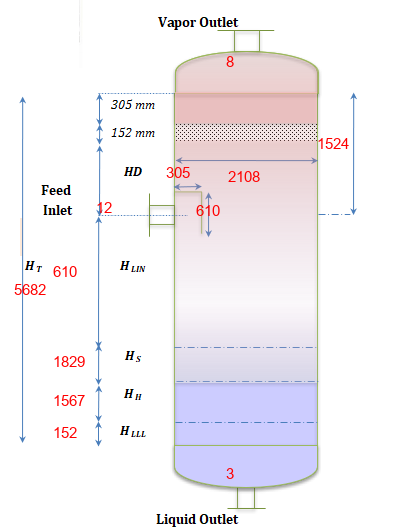

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,2108.2
1,Vessel Tan-Tan Length,L,mm,5681.9526
2,L/D,-,-,2.69517
3,Shell Thickness,ts,mm,84.80739
4,Head Thickness,tH,mm,84.80739
5,Total Weight,W,kg,31499.66872
6,Inlet Nozzle size,dF,inch,12.0
7,Liquid Outlet Nozzle size,dL,inch,3.0
8,Vapor Outlet Nozzle size,dv,inch,8.0
9,Height To Feed Nozzle,H_LIN,mm,609.6


In [3]:
#----------- 2 phase Vertical Separator---------------------#
def estimate_LLL(calculations_options,D,P):
    D_ft = D/12
    D_array = np.array([0,4,6,8,10,12,16])
    LLL_array = np.array([9,9,10,11,12,13,15])
    if calculations_options == 'Two Phase (Gas - Oil) Vertical separator: As per API 12J':
        
        if D_ft <= 8 and P < 300:
            LLL = 15
        else:
            LLL = 6
    elif calculations_options == 'Two Phase (Gas - Oil) Horizontal Separator: As per API 12J':
        LLL = int(np.interp(D_ft,D_array,LLL_array))   
        # LLL = 0.5*D_ft + 7 
    return LLL/12


#----------- 2 phase Vertical Separator---------------------#
def calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=False):
    # This function Calculates The Total Height given the diameter
    HLLL = estimate_LLL('Two Phase (Gas - Oil) Vertical separator: As per API 12J',D_vd*12,P)
    HH = max(V_H/(np.pi*0.25*(D_vd**2)),1)
    HS = max(V_S/(np.pi*0.25*(D_vd**2)),6)


    d_n = inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)

    if inlet_divertor == True:
        HLIN = 12 + d_n
    else:
        HLIN = 12 + d_n*0.5
    HLIN = HLIN/ 12
    if mist_eliminator == True:
        H_D = 24 +0.5*d_n 
        H_D += 6+12
        H_D = max((0.5*D_vd)+1.5,H_D/12) # HD in ft 
    else:
        H_D = 36 + 0.5 *d_n 
        H_D = max(0.5*D_vd,H_D/12) # HD in ft 
   

    H_total=HLLL + HH + HS + HLIN + H_D 
    if only_return_L == False:
        return HLLL,HH,HS,d_n,HLIN,H_D,H_total
    else:
        return H_total

def optimize_vessel_design_V2P(vars,P,T,V_H,V_S,inlet_divertor,mist_eliminator,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,return_output = False):
    D_vd = float(vars)

    HLLL,HH,HS,d_n,HLIN,HD,H_total = calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=False)
    # print('Total Height is {} ft or {} mm'.format(H_total,H_total*304.8))
    # print(HLLL , HH , HS , HLIN , HD )
    D = nearest_size_in(D_vd,convert_from_ft_to_in = True)
    LD = H_total/(D/12)
    #print(D,D_vd,U_v,K,Qv,Ql)
    W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D/12,H_total,17500,1/16,'Elliptical heads')

    # print('Weight is {} lbs,L is {} ft and D is {} in. L/D is {}'.format(W,H_total,D,LD))
    # print('------------------')
    if return_output == False:
        return W 
    else:
        result_list = [W,H_total,D,t,As,AH,P,T,HLLL,HH,HS,d_n,HLIN,HD,H_total,head_type]
    return result_list
def constraint_VP2_1(x,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction):
	# 
    D_vd = x[0]
    H_total = calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=True)
    return (H_total /x[0]) - 2
def constraint_VP2_2(x,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction):
	# 
    D_vd = x[0]
    H_total = calculate_H_4_V2P(D_vd,inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,only_return_L=True)
    return 2.5 - (H_total /x[0])



def detailed_V2P(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
    gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T = operating_conditions
    T_R = T +460
    hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
    #k_GPSA_calculations(P,None,rho_gas,rho_oil,0.013,dropletsize=100)
    # calculate terminal velocity
    K = k_GPSA_calculations(P,'Separator with mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
    U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
    # set U_v = 0.75 U_t
    U_v = 0.75* U_t
    Qv = Qg_lb /(3600*rho_gas)
    Ql = Q_oil_lb/(60*rho_oil)
    V_H , V_S = hold_up_time*Ql ,surge_time*Ql
    D_vd = np.sqrt(((4*Qv)/(np.pi*U_v))) # Inside diameter in ft

    con1= {'type':'ineq', 'fun': constraint_VP2_1,'args':(inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)}
    con2 = {'type':'ineq', 'fun': constraint_VP2_2,'args':(inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)}
    cons=[con1,con2]
    initial_guess = [D_vd]
    bounds = [(1,20)]
    result =minimize(optimize_vessel_design_V2P,args=(P,T,V_H,V_S,inlet_divertor,mist_eliminator,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
    result_list = optimize_vessel_design_V2P(result.x,P,T,V_H,V_S,inlet_divertor,mist_eliminator,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction,return_output=True)
    W,L,D,t,As,AH,P_d,T_d,HLLL,HH,HS,d_n,HLIN,HD,H_total,head_type = result_list
    #print('Weight is {} lbs, D is {} ft  and L is {} ft.'.format(W,D/12,L))
    gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
    liquid_outlet_D = inlet_nozzzle_sizing(Ql/60,0,rho_oil,0,1,True)
    LD = L*12/D

    Dims_results = [d_n, gas_outlet_D,D*25.4,H_total*304.8,HLIN*304.8,HS*304.8,HH*304.8,HLLL*304.8,HD*304.8,liquid_outlet_D]
    for i,j in enumerate(Dims_results):
        Dims_results[i] = round(float(j))
    coord = [(96,199),(226,53),(228,168),(14,281),(53,263),(53,353),(53,392),(53,424),(317,135),(226,465)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
    if inlet_divertor:
        coord.append((166,164)) # roof
        Dims_results.append(round(d_n*25.4))
        coord.append((196,202)) # face
        Dims_results.append(round(d_n*2*25.4))
    list_of_table = [['Diameter of Drum', 'D', 'mm', D*25.4],
    ['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
    ['L/D','-', '-', LD],
    ['Shell Thickness', 'ts', 'mm', t*25.4],
    ['Head Thickness', 'tH', 'mm', t*25.4],
    ['Total Weight', 'W', 'kg', W*0.453592],
    ['Inlet Nozzle size', 'dF', 'inch', d_n],
    ['Liquid Outlet Nozzle size', 'dL', 'inch', liquid_outlet_D],
    ['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],

    ['Height To Feed Nozzle', 'H_LIN', 'mm', HLIN*304.8],
    ['Surge Liquid Level', 'Hs', 'mm', HS*304.8],
    ['High Liquid Level','HH' , 'mm', HH*304.8],
    ['Low Liquid Level', 'H_LLL', 'mm', HLLL*304.8],

    ['Holdup Time', 'TH', 'min', hold_up_time],
    ['Surge Time', 'TS', 'min',surge_time],
    ['MeshPad', '-', '-', mist_eliminator],
    ['Head Type', '-', '-',head_type],
    ['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
    ['Max. Operating Pressure', 'MOP', 'Barg', P],
    ['Design Pressure', 'DP', 'Barg', P_d],
    ['Design Temperature', 'DT', 'oC', T_d],
    ['Corrosion Allowance', 'C', 'mm', 1.5],
    ['Joint Efficiency', 'E', '-',  0.85]]
    if not mist_eliminator:
        write_results_on_imgs('detailed_method_V2P',Dims_results,coord)
    else:
        write_results_on_imgs('detailed_method_V2P_with_mesh',Dims_results,coord)
    summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
    return summary_table

# Calculations inputs
sep_case = 'Unit Feed Drum'
gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T= operating_conditions = (145600/(145600+46100)),145600,46100,38.83,4.01,975+14.6959,650
inlet_divertor, mist_eliminator = True,True
summary_table = detailed_V2P(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

# 2. Horizontal Two-Phase Sizing
![Example Image](vessel_imgs/detailed_method_V2H_with_mesh.png)

1.  Calculate the vapor volumetric flow rate

2.  Calculate the liquid volumetric flow rate

3.  Calculate vertical terminal vapor velocity:

> U<sub>T</sub> = K\* ((ρ<sub>L</sub>- ρ<sub>v</sub>)/
(ρ<sub>v</sub>))<sup>1/2</sup>

> U<sub>v</sub> =0.75\* U<sub>T</sub>

4.  Select holdup time from table 2 and calculate the holdup volume

> V<sub>H</sub> = T<sub>H</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

5.  If surge volume isn’t specified. Select a surge time from table 2
    and calculate surge volume

> V<sub>S</sub> = T<sub>S</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

6.  Obtain an estimate L/D from table 5 and initially calculate the
    diameter according to:

Calculate the total cross section area

7.  Calculate the low liquid level height H<sub>LLL</sub>, using table 3
    or

> H<sub>LLL</sub> = 0.5D+ 7 ,in.

Where D in ft and round up to the nearest in, if D \< 4 ft,
> H<sub>LLL</sub> = 9 in.

8.  Using H<sub>LLL</sub>/D, obtain A<sub>LLL</sub>/A<sub>T</sub> using
    table 6 and calculate the low liquid area, A<sub>LLL</sub>.

9.  If there’s no mist eliminator pad, the minimum height of the vapor
    disengagement area (A<sub>v</sub>) is the larger of 0.2D or 1 ft. if
    there’s a mist eliminator, the minimum height is the larger of 0.2D
    or 2 ft. Using H<sub>v</sub>/D, obtain A<sub>v</sub>/A<sub>t</sub>
    using table 6 and calculate A<sub>v</sub>.

10.  Calculate the minimum length to accommodate the liquid holdup/surge:

> L = (V<sub>H</sub> + V<sub>S</sub>) / (A<sub>T</sub> – A<sub>v</sub>
> –A<sub>LLL</sub>) , ft

11.  Calculate the liquid dropout time,

> *Φ* = H<sub>v</sub> / U<sub>v</sub>

12.  Calculate the actual vapor velocity U<sub>VA</sub>:

U<sub>VA</sub> = Q<sub>v</sub>/A<sub>v</sub>

13.  Calculate the minimum length required for vapor-liquid
    disengagement, L<sub>min</sub>:

> L<sub>min\ =</sub> U<sub>VA</sub> *Φ* , ft

14.  Ensure that 1.2 \> L/L<sub>min</sub> \> 0.8 by manipulating
    H<sub>v</sub> (increase if L/L<sub>min</sub> \>1.2 and vice versa),
    make sure H<sub>v</sub> doesn’t reach H<sub>v</sub> minimum
    specified in step 9. Manipulate D if H<sub>v</sub> minimum is
    reached.

15.  Calculate the thickness of the shell and heads according to table 7.

16.  Calculate the surface area of the shell and heads according to table
    7.

17.  Calculate the approximate vessel weight according to table 7.

18.  Increase/Decrease D until L/D is within \[1.5 – 6\]

19.  With the optimum vessel size (minimum weight), calculate normal and
    high liquid levels.

> A<sub>NLL</sub> = A<sub>LLL</sub> + V<sub>H</sub> /L

> With A<sub>NLL</sub>/A<sub>T</sub> obtain H<sub>NLL</sub> from table 6

> H<sub>HLL</sub> = D - H<sub>v</sub>

<sub>  
</sub>


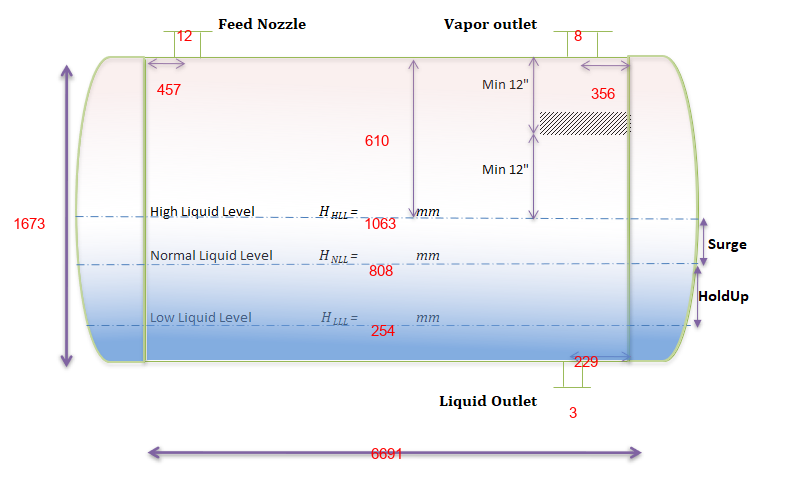

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,1672.78184
1,Vessel Tan-Tan Length,L,mm,6691.12735
2,L/D,-,-,4.0
3,Shell Thickness,ts,mm,67.61952
4,Head Thickness,tH,mm,67.61952
5,Total Weight,W,kg,21900.41999
6,Inlet Nozzle size,dF,inch,12.0
7,Liquid Outlet Nozzle size,dL,inch,3.0
8,Vapor Outlet Nozzle size,dv,inch,8.0
9,High Liquid Level,HHLL,mm,1063.18184


In [4]:
def find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = True):

	Lmin_Ltime , Lmin_V	= -10 , -2 
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated 
			H_v = max(0.2*D,2) 
		else: 
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1


		
		while not (1.2 > (Lmin_Ltime / Lmin_V) > 0.8) and Lmin_Ltime < 0  :
			At = np.pi*0.25*(D**2) # ft2
			HLLL =round_up_to_nearest((0.5*D + 7),1)/12 # feet  #estimate_LLL(calculations_options,D,P)
			#print(D,HLLL)
			HLLL_D = HLLL/D # feet / feet
			#print('HLLL/D equals {}'.format(HLLL_D))
			#print(HLLL_D,10/(5*12),HLLL/D)

			ALLL_At = height_area_conversion(HLLL_D,conversion_to_area = True)
			ALLL = ALLL_At*At # ft^2
			#print(ALLL)
			Hv_D = H_v/(D) # feet / feet
			
			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At
			# 10 calculate minimum length
			Lmin_Ltime = (V_H+V_S)/(At-A_v-ALLL)

			# Liquid dropout time 
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v

			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi
			if not 1.2 > abs(Lmin_Ltime / Lmin_V):
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(Lmin_Ltime / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.01
				Hv_D = H_v/(D)			
			if Lmin_Ltime <0 :
				D +=0.01
				Hv_D = H_v/(D)	

	#print('Hv/D equals {}'.format(Hv_D))
	# minpulate assumed LD ratio and minpulate Hv
	#print('length is {} while min L is {}'.format(Lmin_Ltime , Lmin_V))
	if Lmin_Ltime < Lmin_V:
		L = Lmin_V
	else:
		L = Lmin_Ltime

	A_NLL = ALLL + V_H/L
	A_NLL_ration = A_NLL/At
	H_NLL = height_area_conversion(A_NLL_ration ,conversion_to_area = False)*D
	H_HLL = D- H_v
	LD = float(L/D)	
	if return_output_LD == False:
		return LD
	else:
		result_list = [At,HLLL,HLLL_D,ALLL_At,ALLL,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,H_v,min_Hv,D]
		return result_list
def optimize_vessel_design(vars,P,T,V_H,V_S,U_v,Qv,mist_eliminator,return_output = False):
	D = float(vars) 
	#D = ((4*(V_H + V_S))/(np.pi*0.6*LD))**(1/3) # D in feet
	#D = round_up_to_nearest(D,0.5)
	At,HLLL,HLLL_D,ALLL_At,ALLL,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,H_v,min_Hv,D = find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = True)
	W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D,L,17500,1/16,'Elliptical heads')
	# print('HLLL is {} ft, NLL is {} while H_HLL is {} ft and Hv is {} ft'.format(HLLL,H_NLL,H_HLL,H_v))
	# print('Weight is {} lbs,L is {} ft and D is {} ft. L/D is {}'.format(W,L,D,LD))
	# print('----------------------------------')
	if return_output == False:
		return W 
	else:
		result_list = [W,t,As,AH,P,T,At,HLLL,HLLL_D,ALLL_At,ALLL,H_v,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,D,min_Hv,head_type]
		return result_list
def constraint_HP2_6(x,P,V_H,V_S,U_v,Qv,mist_eliminator):
	D = x[0]
	return LD_estimate(P,return_range=True)[1] - find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = False)
def constraint_HP2_1_5(x,P,V_H,V_S,U_v,Qv,mist_eliminator):
	D = x[0]
	return find_LD_H2P(D,V_H,V_S,U_v,Qv,mist_eliminator,return_output_LD = False) - LD_estimate(P,return_range=True)[0]

#-----------------------2 phase horizontal--------------------#


def detailed_V2H(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):

	gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T = operating_conditions
	T_R = T +460
	hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
	K = k_GPSA_calculations(P,'Separator with mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
	U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
	# set U_v = 0.75 U_t
	U_v = 0.75* U_t # ft/s
	Qv = Qg_lb /(3600*rho_gas)
	Ql = Q_oil_lb/(60*rho_oil)
	V_H , V_S = hold_up_time*Ql ,surge_time*Ql # ft3

	LD = LD_estimate(P) # LD initial estimate (assumption)
	initial_D = ((4*(V_H + V_S))/(np.pi*0.6*LD))**(1/3) # D in feet
	#print('initial_D {} ft'.format(initial_D))
	if mist_eliminator: # used for initial guess and to be minpulated 
		H_v = max(0.2*initial_D,2) 
	else: 
		H_v = max(0.2*initial_D,1) # Hv in feet

	d_n = inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)
	#print(LD,H_v,initial_D)

	con1,con2 = {'type':'ineq', 'fun': constraint_HP2_6,'args':(P,V_H,V_S,U_v,Qv,mist_eliminator)},{'type':'ineq', 'fun': constraint_HP2_1_5,'args':(P,V_H,V_S,U_v,Qv,mist_eliminator)}
	cons=[con1,con2]
	initial_guess = [initial_D]

	bounds = [(1,20)]

	result =minimize(optimize_vessel_design,args=(P,T,V_H,V_S,U_v,Qv,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
	result_list = optimize_vessel_design(result.x,P,T,V_H,V_S,U_v,Qv,mist_eliminator,return_output=True)
	W,t,As,AH,P_d,T_d,At,HLLL,HLLL_D,ALLL_At,ALLL,H_v,Hv_D,A_v,Lmin_Ltime,phi,U_VA,Lmin_V,L,A_NLL,H_NLL,H_HLL,LD,D,min_Hv,head_type = result_list
	#print('Weight is {} lbs, D is {} ft vs Hv is {} ft and L is {} ft.'.format(W,D,H_v,L))
	gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
	liquid_outlet_D = inlet_nozzzle_sizing(Ql/60,0,rho_oil,0,1,True)
	gas_N = Calculate_N(gas_outlet_D)
	liquid_N = Calculate_N(liquid_outlet_D)
	Feed_N = Calculate_N(d_n)

	Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_outlet_D,liquid_N,D*304.8,L*304.8,HLLL*304.8, H_NLL*304.8, H_HLL*304.8,H_v*304.8]
	for i,j in enumerate(Dims_results):
		Dims_results[i] = round(float(j))
	coord = [(176,27),(157,81),(574,27),(591,85),(569,404),(574,353),(13,215),(371,445),(371,322),(369,262),(364,215),(365,132)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
	list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Liquid Outlet Nozzle size', 'dL', 'inch', liquid_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],

	['High Liquid Level','HHLL' , 'mm', H_HLL*304.8],
	['Normal Liquid Level', 'HNLL', 'mm', H_NLL*304.8],
	['Low Liquid Level', 'HLL', 'mm', HLLL*304.8],

	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', '-', '-', 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]


	if not mist_eliminator:
		write_results_on_imgs('detailed_method_V2H',Dims_results,coord)
	else:
		write_results_on_imgs('detailed_method_V2H_with_mesh',Dims_results,coord)
	summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
	return summary_table
# Calculations inputs
sep_case = 'Unit Feed Drum'
gas_mass_fraction,Qg_lb,Q_oil_lb,rho_oil,rho_gas,P,T= operating_conditions = (145600/(145600+46100)),145600,46100,38.83,4.01,975+14.6959,650
inlet_divertor, mist_eliminator = True,True
summary_table = detailed_V2H(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

# 3. Vertical Three-Phase Separator Sizing
![Example Image](vessel_imgs/detailed_method_V3P_divertor_with_mesh.png)
1.  Calculate vertical terminal vapor velocity:

> U<sub>T</sub> = K\* ((ρ<sub>L</sub>- ρ<sub>v</sub>)/
(ρ<sub>v</sub>))<sup>1/2</sup>

> U<sub>v</sub> =0.75\* U<sub>T</sub>

2.  Calculate the vapor volumetric flow rate

> Q<sub>v</sub>= W<sub>v</sub> / (3600\* ρ<sub>v</sub>) ,ft<sup>3</sup>/s

3.  Calculate the vessel (inside) diameter, if there’s a mist eliminator
    and 3-6 inches to accommodate a support ring and round it up to the
    nearest 6 in.

> D<sub>vd</sub> = (4\*Q<sub>v</sub> / π\*U<sub>v</sub>) ,ft

4.  Calculate the settling velocity of the heavy liquid out of the light
    liquid using Stokre’s law (the maximum is 10 in./min)

> U<sub>HL</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
> ρ<sub>L</sub>)/μ<sub>L</sub>

Where K<sub>s</sub> is obtained from table 1 or is calculated

5.  Calculate the settling velocity of the heavy liquid out of the light
    liquid using Stokre’s law (the maximum is 10 in./min)

> U<sub>LH</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
> ρ<sub>L</sub>)/μ<sub>H</sub>

Where K<sub>s</sub> is obtained from table 1 or is calculated

6.  Calculate the light and heavy liquid volumetric flow rates,
    Q<sub>LL</sub> and Q<sub>HL</sub>

> Q<sub>LL</sub> = W<sub>LL</sub> / 60 ρ<sub>L</sub>

> Q<sub>HL</sub> = W<sub>HL</sub> / 60 ρ<sub>H</sub>

7.  Assume H<sub>L</sub> = 1 ft (minimum) nad calculate settling time
    for the heavy liquid droplets to settle throught the distance

> t<sub>HL</sub> = 12H<sub>L</sub> / U<sub>HL</sub>

8.  Assume H<sub>L</sub> = 1 ft (minimum) nad calculate settling time
    for the heavy liquid droplets to settle throught the distance

> t<sub>LH</sub> = 12H<sub>H</sub> / U<sub>LH</sub>

9.  If there is a baffle plate, calculate the area:



a.  Calculate ρ<sub>L</sub>- ρ<sub>v</sub>

b.  Assume H<sub>T</sub> (9 in minimum) and Calculate H<sub>L</sub> +
H<sub>R</sub> <br>

c.  Use figure 3 to obtain G <br>

d.  Calculate A<sub>D</sub>

e.  Assume W<sub>D</sub> = 4 in.

f.  Calculate W<sub>D</sub>/D

g.  Use table 3 to determine A<sub>D</sub>/A

h.  Calculate A = 0.25\*π\*D<sup>2</sup>

i.  Calculate A<sub>D</sub>

j. Select the larger value of A<sub>D</sub>

k. Calculate the area of the baffle plate = setting area for the light
    liquid; A<sub>L</sub> = A – A<sub>D</sub>



10.  Calculate the residence time of each phase based on the volumes
    occupied by the light and heavy phases:

> ϴ<sub>LL</sub> = H<sub>L</sub>A<sub>L</sub>/Q<sub>LL</sub>

> ϴ<sub>HL</sub> = H<sub>H</sub>A<sub>H</sub>/Q<sub>HL</sub>

Make sure that ϴ<sub>LL</sub> \> t<sub>HL</sub> and ϴ<sub>HL</sub> \>
> t<sub>LH</sub>. Otherwise, reapeat steps from 7 to 10.

11.  Calculate the height of the light liquid above the outlet (holdup
    height) based on the required holdup time:

> H<sub>R</sub> = Q<sub>LL</sub>T<sub>H</sub>/A<sub>L</sub> and check the
value with the previously assumed.

12.  Calculate the vessel height using these guidelines:

> H<sub>A</sub> = 6 in. minimum

> H<sub>BN</sub> = 0.5d<sub>N</sub> + greater of (2 ft or H<sub>s</sub>
+0.5 ft)

> H<sub>D</sub> = 0.5D or a minimum of

> H<sub>D</sub> = 36 + 0.5\*d<sub>N</sub> (without mist eliminator)

> H<sub>D</sub> = 24 + 0.5\*d<sub>N</sub> (with mist eliminator)

> H<sub>T</sub> = H<sub>H</sub> + H<sub>L</sub> + H<sub>R</sub> +
> H<sub>A</sub> + H<sub>BN</sub> + H<sub>D</sub>

If mist eliminator is used, additional height is added.

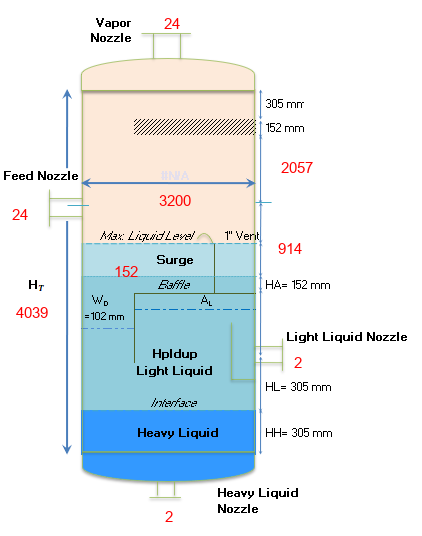

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,3200.4
1,Vessel Tan-Tan Length,L,mm,4038.6
2,L/D,-,-,1.2619
3,Shell Thickness,ts,mm,21.12608
4,Head Thickness,tH,mm,21.12608
5,Total Weight,W,kg,10435.72947
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,2.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [5]:
#--------------------Vertical 3 phase----------------#
def optimize_V3P_design(vars,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output = False):
    D_vd,H_L,H_H,H_R = vars
    #H_L,H_H = 1,1 
    t_HL = (12*H_L)/U_HL
    t_LH = (12*H_H)/U_LH
    # 9. if there's a baffle plate
    #H_R = 1 # 12 in or 1 ft is assumed in assumed
    H_R_H_L = H_R + H_L
    y = rho_oil-rho_gas 
    #print(H_R_H_L*12)

    G = calclculate_G(H_R_H_L*12,y)
    # print('G Value is {}'.format(G))
    A_D1 = 7.48*60*(Q_LL+Q_HL)/G 

    # Assume W_D = 4 inches
    W_D = 4
    WD_D = W_D/(D_vd*12)
    At = np.pi*0.25*(D_vd**2) # ft2
    Ad_At = height_area_conversion(WD_D,conversion_to_area = True)
    A_D2 = At*Ad_At
    Ad = max(A_D1,A_D2)
    Al,Ah = (At-Ad), At

    PHI_LL = (Al*H_L)/Q_LL
    PHI_HL = (Ah*H_H)/Q_HL
    # if phi_LL < t_HL or phi_HL < t_LH, increase the diameter and repeat the procedure from step 7 (liquid separation is controlling)
    H_R_calculated = Q_LL*hold_up_time/Al # Check the value with that assumed in step 9b
    # print('Calculated HR is {}'.format(H_R))
    H_S = max((Q_LL + Q_HL)*surge_time/At,6/12)
    # 12. Calculate the vessel height using the guidelines
    H_A = 6 /12 # feet min.
    H_BN = 0.5*(d_n/12)+max(2,H_S + 0.5) # feet

    if mist_eliminator == True:
        H_D = 24 +0.5*d_n 
        H_D += 6+12
        H_D = max((0.5*D_vd)+1.5,H_D/12) # HD in ft 
    else:
        H_D = 36 + 0.5 *d_n 
        H_D = max(0.5*D_vd,H_D/12) # HD in ft 
    H_t = L = H_H+H_L+H_R+H_A + H_BN+H_D # total height in feet
    # print(H_H,H_L,H_R,H_A , H_BN,H_D )
    LD = H_t/D_vd
    W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D_vd,L,17500,1/16,'Elliptical heads')

    # print('Weight is {} lbs,L is {} ft and D is {} ft. L/D is {}'.format(W,L,D_vd,LD))
    # print('----------------------------------')
    if return_output == False:
        return H_R - H_R_calculated
    else:
        result_list = [W,L,D_vd,LD,t,As,AH,P,T,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H,head_type]
        return result_list

def phi_LL_constraint(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator):
    W,L,D_vd,LD,t,As,AH,P,T,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H,head_type = optimize_V3P_design(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output=True)
    return PHI_LL - t_HL
def phi_HL_constraint(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator):
    W,L,D_vd,LD,t,As,AH,P,T,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H ,head_type= optimize_V3P_design(x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output=True)
    return PHI_HL - t_LH

def detailed_V3P(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
    Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T = operating_conditions
    hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]



    Q_L_mix = Q_oil_lb+ Q_water_lb
    rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
    Ql_mix = Q_L_mix/(60*rho_L)
    # 1. Calculate Terminal Velocity   

    K = k_GPSA_calculations(P,'Use York',rho_gas,rho_oil,0.013,dropletsize=100)
    U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
    # set U_v = 0.75 U_t
    U_v = 0.75* U_t # ft/s
    Qv = Qg_lb /(3600*rho_gas)
    Qll = Q_oil_lb/(60*rho_oil)
    Qhl = Q_water_lb/(60*rho_water)
    gas_vol_fraction = Qv*60/((Qv*60)+Qll+Qhl)
    #print(gas_vol_fraction )
    D_vd = np.sqrt(((4*Qv)/(np.pi*U_v))) # Inside diameter in ft
    #print('Before D {}'.format(D_vd))
    if mist_eliminator:
        D_vd = round_up_to_nearest((D_vd*12)+3,6)/12
        #print('After D {}'.format(D_vd))
    sg_oil = rho_oil/62.4
    U_HL = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True)
    U_LH = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False)
    #print(U_HL,U_LH)
    Q_LL = Q_oil_lb/(60*rho_oil)
    Q_HL = Q_water_lb/(60*rho_water)
    #print(Q_LL,Q_HL)
    d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
    # 7./8. Assume H_L = 1 # ft which is minimum
    initial_guess = [D_vd,1,1,1]
    bounds = [(D_vd,20),(1,D_vd),(1,D_vd*2),(1,D_vd)]
    con1= {'type':'ineq', 'fun': phi_LL_constraint,'args':(P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator)}
    con2 = {'type':'ineq', 'fun': phi_HL_constraint,'args':(P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator)}
    cons=[con1,con2]
    result =minimize(optimize_V3P_design,args=(P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
    result_list = optimize_V3P_design(result.x,P,T,d_n,rho_oil,rho_gas,U_HL,U_LH,Q_LL,Q_HL,hold_up_time,surge_time,mist_eliminator,return_output=True)
    W,L,D,LD,t,As,AH,P_d,T_d,t_HL,t_LH,PHI_LL,PHI_HL,G,W_D,At,Ad,H_S,H_A,H_BN,H_D,H_R,H_L,H_H,head_type = result_list
    # print('Weight is {} lbs, D is {} ft and L is {} ft.'.format(W,D,L))
    # print('HH {}, HL {}, HR {}, H_A {}, H_BN {}, H_D {}'. format(H_H,H_L,H_R,H_A,H_BN,H_D))
    # print('H_R is {},phi_LL is {} while t_HL is {}, phi_HL is {} while t_LH is {}'.format(H_R,PHI_LL , t_HL,PHI_HL , t_LH))

    gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
    liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
    liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)



    Dims_results = [d_n,gas_outlet_D,liquid_L_outlet_D,liquid_H_outlet_D ,D*304.8,L*304.8,H_D*304.8,H_BN*304.8,H_S*304.8] # feed D,gas d, Light D, Heavy D,D,L,H_D,H_BN,H_S
    for i,j in enumerate(Dims_results):
        Dims_results[i] = round(float(j))
    coord = [(12,206),(164,15),(294,354),(165,508),(159,192),(16,304),(281,159),(278,240),(114,263)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
    list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
    ['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
    ['L/D','-', '-', LD],
    ['Shell Thickness', 'ts', 'mm', t*25.4],
    ['Head Thickness', 'tH', 'mm', t*25.4],
    ['Total Weight', 'W', 'kg', W*0.453592],
    ['Inlet Nozzle size', 'dF', 'inch', d_n],
    ['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
    ['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
    ['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
    ['Disengagement height','H_D' , 'mm', H_D*304.8],
    ['Height from above baffle to feed nozzle','H_BN' , 'mm', H_BN*304.8],
    ['Surge Height','H_S' , 'mm', H_S*304.8],
    ['Liquid Level Above baffle','H_A' , 'mm', H_A*304.8],
    ['Height from liquid nozzle to baffle', 'H_R', 'mm', H_R*304.8],
    ['Light Liquid Level', 'H_LL', 'mm', H_L *304.8],
    ['Heavy Liquid Level', 'H_HL', 'mm', H_H *304.8],
    ['Holdup Time', 'TH', 'min', hold_up_time],
    ['Surge Time', 'TS', 'min',surge_time],
    ['MeshPad', '-', '-', mist_eliminator],
    ['Head Type', '-', '-', head_type],
    ['Material/Alloy grade and type:', '-', '-', 'CS'],
    ['Max. Operating Pressure', 'MOP', 'Barg', P],
    ['Design Pressure', 'DP', 'Barg', P_d],
    ['Design Temperature', 'DT', 'oC', T_d],
    ['Corrosion Allowance', 'C', 'mm', 1.5],
    ['Joint Efficiency', 'E', '-',  0.85]]

    if not mist_eliminator and inlet_divertor:
        write_results_on_imgs('detailed_method_V3P_divertor',Dims_results,coord)
    else:
        write_results_on_imgs('detailed_method_V3P_divertor_with_mesh',Dims_results,coord)
    summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
    return summary_table

# Calculations inputs
Qg_lb, rho_gas = 415000,0.6973 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 16500,1300,53.95,62.11
mu_oil,mu_water = 0.63, 0.764
sg_oil = rho_oil/rho_water
P = 165 # psia
T = 100 # assumed
hold_up_time,surge_time=25,5
inlet_divertor, mist_eliminator = True,True
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
sep_case = 'Unit Feed Drum'
summary_table= detailed_V3P(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

# 4. Horizontal Three-Phase Separator Sizing (No weir, No Boot)
![Example Image](vessel_imgs/detailed_method_V3H_with_mesh.png)

1.  Calculate the vapor volumetric flow rate

> Q<sub>v</sub>= W<sub>v</sub> / (3600\* ρ<sub>v</sub>) ,ft<sup>3</sup>/s

2.  Calculate the light and the heavy liquid volumetric flow rates,
    Q<sub>LL­</sub> and Q<sub>HL</sub>

3.  Calculate vertical terminal vapor velocity:

> U<sub>T</sub> = K\* ((ρ<sub>L</sub>- ρ<sub>v</sub>)/
(ρ<sub>v</sub>))<sup>1/2</sup>

> U<sub>v</sub> =0.75\* U<sub>T</sub>

4.  Select holdup time from table 2 and calculate the holdup volume

> V<sub>H</sub> = T<sub>H</sub> \* Q<sub>L</sub> ,ft<sup>3</sup> , If
surge volume isn’t specified. Select a surge time from table 2 and
calculate surge volume

> V<sub>S</sub> = T<sub>S</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

5.  Obtain L/D from table 7 and initially calculate the diameter
    according to:

> D = (4(V<sub>H</sub> + V<sub>S</sub>)/(0.5π(L/D)))<sup>1/3</sup>

6.  Set the vapor space height, H<sub>v</sub>, the larger of 0.2D or 2
    ft; 1ft if there is no mist eliminator. Using H<sub>v</sub>/D in
    table 3, obtain A<sub>v</sub>/A<sub>T</sub> and calculate
    A<sub>v</sub>.

7.  Set heights of the heavy and light liquids, H<sub>HL</sub> and
    H<sub>LL</sub>

8.  Find (A<sub>HL</sub> + A<sub>LL</sub>) /A<sub>T</sub>, Using
    (H<sub>HL</sub> + H<sub>LL</sub>) /D in table 3, and calculate
    A<sub>HL</sub>+A<sub>LL</sub>

9.  Calculate the minimum length to accommodate the liquid holdup/surge:

> L = (V<sub>H</sub> + V<sub>S</sub>) / (A<sub>T</sub> – A<sub>v</sub>
–(A<sub>HL</sub>+A<sub>LL</sub>) ), ft

10.  Calculate the liquid dropout time:

> Φ = H<sub>v</sub>/U<sub>v</sub>

11.  Calculate the actual vapor velocity:

> U<sub>VA</sub> = Q<sub>v</sub>/A<sub>v</sub>

12.  Calculate the minimum length required for the vapor/liquid
    separation:

> L<sub>min</sub> = U<sub>VA</sub> φ

13.  Ensure that 1.2 \> L/Lmin \> 0.8 by manipulating Hv (increase if
    L/Lmin \>1.2 and vice versa), make sure Hv doesn’t reach Hv minimum
    specified in step 9. Manipulate D if Hv minimum is reached.

14.  Calculate the setting velocities of the heavy liquid out of the
    light liquid phase and the light liquid out of the heavy phase:

> U<sub>HL</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
ρ<sub>L</sub>)/μ<sub>L</sub>

> U<sub>LH</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
ρ<sub>L</sub>)/μ<sub>H</sub>

15.  Calculate the settling times of the heavy liquid out of the light
    phase and the light liquid out of the heavy phase:

> t<sub>HL</sub> = 12 (D-H<sub>v</sub> – H<sub>HL</sub>)/U<sub>HL</sub>

> t<sub>LH</sub> = 12 H<sub>HL</sub> / U<sub>LH</sub>

16.  Calculate the residence times of the light and heavy liquids
> ϴ<sub>HL</sub> = A<sub>HL</sub>L/Q<sub>HL</sub>

> ϴ<sub>LL</sub> = (A<sub>T</sub> – A<sub>v</sub> –
A<sub>HL</sub>)L/Q<sub>LL</sub>

17.  Ensure that ϴ<sub>HL</sub> \> t<sub>LH</sub> and ϴ<sub>LL</sub> \>
    t<sub>LH</sub>. Otherwise, Increase L.

> L = max(t<sub>LH</sub>Q<sub>HL</sub>/A­<sub>HL</sub>,
> t<sub>HL</sub>Q<sub>LL</sub>/(A<sub>T</sub> – A<sub>v</sub> –
A<sub>HL</sub>))

18.  Calculate L/D, ensure L/D is between \[1.5 – 6\] by manipulating D.

19.  Calculate the thickness of the shell and heads according to table 8.

20.  Calculate the surface area of the shell and heads according to table
    8.

21.  Calculate the approximate vessel weight according to table 8.

22.  Using optimum vessel size (minimum wright), calculate the normal and
    high liquid levels:

> H<sub>HLL</sub> = D - H<sub>v</sub>

> A<sub>NLL</sub> = (A<sub>HL</sub> + A<sub>LL</sub>) + V<sub>H</sub>/:

Obtain H<sub>NLL</sub> using Table 3 with the value of
A<sub>NLL</sub>/A<sub>T</sub>.

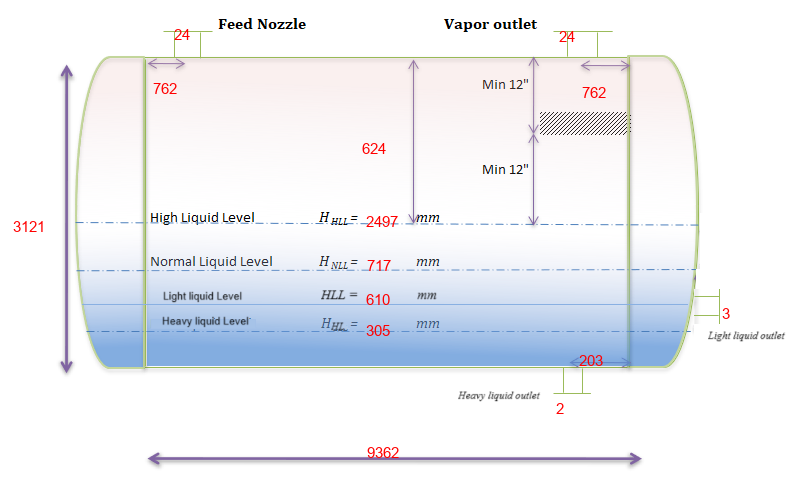

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,3120.66671
1,Vessel Tan-Tan Length,L,mm,9362.00013
2,L/D,-,-,3.0
3,Shell Thickness,ts,mm,11.80294
4,Head Thickness,tH,mm,11.80294
5,Total Weight,W,kg,10022.30833
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,3.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [6]:
#  --------H3P with no boots or weir----------------- # 


def find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= True):
	Lmin_Ltime , Lmin_V	= -10 , -2 
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated 
			H_v = max(0.2*D,2) 
		else: 
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1

		while (not 1.2 > (Lmin_Ltime / Lmin_V) > 0.8) and Lmin_Ltime < 0:
			# feet / feet
			At = np.pi*0.25*(D**2) # ft2
			Hv_D = H_v/(D)		
			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At

			# step 7: set the heights of H_HL and H_LL
			
			A_HL,A_LL = height_area_conversion(H_HL/D,conversion_to_area = True)*At,height_area_conversion(H_LL/D,conversion_to_area = True)*At
			H_HLplusH_LL_At = height_area_conversion((H_HL+ H_LL)/D,conversion_to_area = True)
			A_HLplusA_LL = H_HLplusH_LL_At*At # ft^2
			
			# 9 calculate minimum length
			
			Lmin_Ltime = (V_H+V_S)/(At-A_v-A_HLplusA_LL)

			#calculate actual vapor velocity
			# Liquid dropout time 
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v
			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi
			
			if abs(Lmin_Ltime / Lmin_V) > 1.2 and H_v > min_Hv:
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(Lmin_Ltime / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.02
				Hv_D = H_v/(D)			
			if Lmin_Ltime <0 :
				D +=0.01
				Hv_D = H_v/(D)
	#print('Lmin1 is {} while Lmin2 is {}'.format(round(Lmin_Ltime,2),round(Lmin_V,2)))
	if Lmin_Ltime < Lmin_V:
		L = Lmin_V
	else:
		L = Lmin_Ltime
	#print('Hv/D equals {} as D is {} feet and Hv is {} feet'.format(round(Hv_D,3),D,H_v))
	# print('D is {}, Hv, H_HL,H_LL total is {}'.format(D, (H_v+H_HL+H_LL)))
	# print('At is {} ft2,Av={} ft2,A_HLplusA_LL is {} and D {}, H_V {}, H_HL and H_LL are {} & {}'.format(At, A_v, A_HLplusA_LL,D,H_v,H_HL,H_LL))
	U_HL = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True)
	U_LH = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False)


	t_HL = 12*(D-H_v-H_HL)/U_HL
	t_LH = 12*H_HL/U_LH

	phi_HL = A_HL*L/Q_HL
	phi_LL = (At-A_v-A_HL)*L/Q_LL

	L_max1 = t_LH*Q_HL/A_HL
	L_max2 = (t_HL*Q_LL)/(At-A_v-A_HL)
	L_max = max(L_max1,L_max2)
	#print('max length is {}'.format(round(L_max,2)))
	# step 18 Calculate L/D if LD < 1.5*0.8, decrease, and if L/D > 6*1.2, then increase D
	LD = L/D
	H_HLL = D - H_v 
	A_NLL = (A_HL+A_LL) + V_H/L
	NLL = height_area_conversion(A_NLL/At,conversion_to_area = False)*D
	#print('D is {}, Chosen L is {}, Hv is {}, HLL is {}, NLL is {}, H_HL is {},HLL is {} '.format(D,L,H_v,H_HLL, NLL, H_HL,H_LL))

	if return_output_LD == True:
		return [At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,H_v]
	else:
		return LD
def optimize_vessel_design_H3phase(vars,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,return_output = False):
	D,H_HL,H_LL = vars
	At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,H_v = find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= True)
	W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D,L,17500,1/16,'Dished heads')
	#print(W,L,D,LD)
	#print('---------------------')
	if return_output == False:
		return W
	else:
		result_list = [W,L,D,H_v,H_HL, H_LL ,t,As,AH,P,T,At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,head_type  ]
		return result_list



def LD_constraint_1_HP3_no_weir_or_boot(x,P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water):
	D,H_HL,H_LL = x[0],x[1],x[2]
	return LD_estimate(P,return_range=True)[1] - find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= False)
def LD_constraint_2_HP3_no_weir_or_boot(x,P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water):
	D,H_HL,H_LL = x[0],x[1],x[2]
	return  find_LD(D,U_v,H_HL,H_LL,V_S,V_H,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water,return_output_LD= False) - LD_estimate(P,return_range=True)[0]
def detailed_V3H_no_weir_or_boot(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
	Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T= operating_conditions
	hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
	Q_L_mix = Q_oil_lb+ Q_water_lb
	rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
	Ql_mix = Q_L_mix/(60*rho_L)
	# 1. Calculate Terminal Velocity   
	gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
	#print('mass fraction is {}'.format(round(gas_mass_fraction,3)))
	K = k_GPSA_calculations(P,'Separator without mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
	U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
	# set U_v = 0.75 U_t
	U_v = 0.75 * U_t
	#print('velocity is {} ft/s'.format(U_v))
	Qv = Qg_lb /(3600*rho_gas)
	Qll = Q_oil_lb/(60*rho_oil)
	Qhl = Q_water_lb/(60*rho_water)
	gas_vol_fraction = Qv*60/((Qv*60)+Qll+Qhl)
	V_H , V_S = hold_up_time*Qll ,surge_time*Qll # ft3
	#print('VHoldup and Vsurge equals {} and {} , total is {} ft3 '.format(round(V_H),round(V_S),(round(V_H)+round(V_S))))
	Q_LL = Q_oil_lb/(60*rho_oil) # ft3/min
	Q_HL = Q_water_lb/(60*rho_water) # ft3/min
	#step 5
	LD = LD_estimate(P) 
	#print('assumed LD is {}'.format(round(LD)))# LD initial estimate (assumption)
	initial_D = round(((4*(V_H + V_S))/(np.pi*0.5*LD))**(1/3)) # D in feet
	sg_oil = rho_oil/62.4
	#print(initial_D)
	#print('-----------------------------------------')
	con1 ={'type':'ineq', 'fun': LD_constraint_1_HP3_no_weir_or_boot, 'args':(P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water)}
	con2 = {'type':'ineq', 'fun': LD_constraint_2_HP3_no_weir_or_boot, 'args':(P,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,sg_oil,rho_oil,rho_water,mu_oil,mu_water)}#, {'type':'eq', 'fun': true_LD_constraint, 'args':(V_S,V_H)},,{'type':'eq', 'fun': NLL_constraint, 'args':(V_S,V_H)}
	cons=[con1,con2,]
	initial_guess = [initial_D,1,1]
	if mist_eliminator:
		min_Hv = 2
	else: min_Hv = 1
	bounds = [(1,20),(1,2),(1,2)]
	result =minimize(optimize_vessel_design_H3phase,args=(P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) #, constraints= cons)
	result_list = optimize_vessel_design_H3phase(result.x,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,mist_eliminator,return_output=True)
	W,L,D,H_v,H_HL, H_LL,t,As,AH,P_d,T_d,At,Hv_D,A_HL,A_LL,Lmin_Ltime,phi ,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,t_LH,phi_HL,phi_LL,L_max,LD,H_HLL,A_NLL,NLL,head_type = result_list
	#print('Weight is {}, D is {} vs Hv is {} and L is {},LD assumed {}'.format(W,D,H_v,L,result.x[1]))
	d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
	gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
	liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
	liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)
	gas_N = Calculate_N(gas_outlet_D)
	liquid_L_N = Calculate_N(liquid_L_outlet_D)
	liquid_H_N = Calculate_N(liquid_H_outlet_D)
	Feed_N = Calculate_N(d_n)

	Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_L_outlet_D,liquid_H_outlet_D,liquid_H_N  ,D*304.8,L*304.8,H_HLL*304.8, NLL*304.8, (H_LL+H_HL)*304.8,H_HL*304.8,H_v*304.8]
	for i,j in enumerate(Dims_results):
		Dims_results[i] = round(float(j))
	coord = [(174,26),(153,80),(559,28),(582,84),(722,305),(556,400),(579,352),(13,218),(367,444),(366,213),(367,257),(366,291),(366,322),(362,140)] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
	list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
	['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
	['High Light Liquid Level','HHLL' , 'mm', H_HLL*304.8],
	['Normal Light Liquid Level', 'HNLL', 'mm', NLL*304.8],
	['Low Light Liquid Level', 'HLL', 'mm', H_LL*304.8],
	['Heavy Liquid Level', 'HHL', 'mm', H_HL*304.8],
	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]
	if not mist_eliminator:
		write_results_on_imgs('detailed_method_V3H',Dims_results,coord)
	else:
		write_results_on_imgs('detailed_method_V3H_with_mesh',Dims_results,coord)
	summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
	return summary_table

# Calculations inputs  
Qg_lb, rho_gas = 235000,0.19 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 45000,7500,40.5,62.00
mu_oil,mu_water = 0.24, 0.682
sg_oil = rho_oil/rho_water
P = 25 + 14.6959 # psia
T = 100 # F
inlet_divertor, mist_eliminator = False,True
sep_case = 'Unit Feed Drum'
#sep_case ='Separators: Feed to column'
#operating_conditions = (1940.8372169999998, 0.145070322, 31128.462782999995, 11023.099999999999, 40.779063400800005, 61.817531160436836, 0.4, 0.5960689122848406, 14.2233, 113.0)
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
summary_table = detailed_V3H_no_weir_or_boot(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table


# 5. Horizontal Three-Phase Separator Sizing (With Boot)
![Example Image](vessel_imgs/detailed_method_V3H_boot_with_mesh.png)

1.  Calculate the vapor volumetric flow rate

> Q<sub>v</sub>= W<sub>v</sub> / (3600\* ρ<sub>v</sub>) ,ft<sup>3</sup>/s

2.  Calculate the light and the heavy liquid volumetric flow rates,
    Q<sub>LL­</sub> and Q<sub>HL</sub>

3.  Calculate vertical terminal vapor velocity:

> U<sub>T</sub> = K\* ((ρ<sub>L</sub>- ρ<sub>v</sub>)/
(ρ<sub>v</sub>))<sup>1/2</sup>

> U<sub>v</sub> =0.75\* U<sub>T</sub>

4.  Select holdup time from table 2 and calculate the holdup volume

> V<sub>H</sub> = T<sub>H</sub> \* Q<sub>L</sub> ,ft<sup>3</sup> , If
surge volume isn’t specified. Select a surge time from table 2 and
calculate surge volume

> V<sub>S</sub> = T<sub>S</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

5.  Obtain L/D from table 7 and initially calculate the diameter
    according to:

> D = (4(V<sub>H</sub> + V<sub>S</sub>)/(0.6π(L/D)))<sup>1/3</sup>

6.  Set the vapor space height, H<sub>v</sub>, the larger of 0.2D or 2
    ft; 1ft if there is no mist eliminator. Using H<sub>v</sub>/D in
    table 3, obtain A<sub>v</sub>/A<sub>T</sub> and calculate
    A<sub>v</sub>.

7.  Set the light liquid heights in the vessel and the boot
    H<sub>LLV</sub>,H<sub>LLB</sub>. (1 ft each)

8.  Calculate the cross-sectional area of the light liquid above the
    bottom of the vessel, A<sub>LLV</sub>, using H<sub>LLV</sub>/D in
    table 3.

9.  Calculate the minimum length to accommodate the liquid holdup/surge:

> L = (V<sub>H</sub> + V<sub>S</sub>) / (A<sub>T</sub> – A<sub>v</sub>
–A<sub>LLV</sub>) , ft

10.  Calculate the liquid dropout time, φ, φ =
    H<sub>v</sub>/U<sub>v</sub>

11.  Calculate the actual vapor velocity:

> U<sub>VA</sub> = Q<sub>v</sub>/A<sub>v</sub>

12.  Calculate the minimum length required for the vapor/liquid
    separation:

> L<sub>min</sub> = U<sub>VA</sub> φ

13.  Ensure that 1.2 \> L/L<sub>min</sub> \> 0.8 by manipulating
    H<sub>v</sub> (increase if L/L<sub>min</sub> \>1.2 and vice versa),
    make sure H<sub>v</sub> doesn’t reach H<sub>v</sub> minimum
    specified in step 6. Manipulate D if H<sub>v</sub> minimum is
    reached.

14.  Calculate the setting velocities of the heavy liquid out of the
    light liquid phase:

> U<sub>HL</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
ρ<sub>L</sub>)/μ<sub>L</sub>

15.  Calculate the settling times of the heavy liquid out og the light
    phase and the light liquid out of the heavy phase:

> t<sub>HL</sub> = 12 (D-H<sub>v</sub> – H<sub>HL</sub>)/U<sub>HL</sub>

16.  Calculate the residence times of the light and heavy liquids

> ϴ<sub>LL</sub> = (A<sub>T</sub> – A<sub>v</sub>)L/Q<sub>LL</sub>

17.  Ensure ϴ<sub>LL</sub> \> t<sub>HL</sub>, Otherwise, Increase vessel
    length.

> L = t<sub>HL</sub>Q<sub>LL</sub>/ (A<sub>T</sub> – A<sub>v</sub>)

18.  Calculate L/D, ensure L/D is between \[1.5 – 6\] by manipulating D.

19.  Calculate the thickness of the shell and heads according to table 8.

20.  Calculate the surface area of the shell and heads according to table
    8.

21.  Calculate the approximate vessel weight according to table 8.

22.  Using optimum vessel size (minimum weight), calculate the normal and
    high liquid levels:

> H<sub>HLL</sub> = D - H<sub>v</sub>

> A<sub>NLL</sub> = (A<sub>HL</sub> + A<sub>LL</sub>) + V<sub>H</sub>/L

Obtain H<sub>NLL</sub> using Table 3 with the value of
A<sub>NLL</sub>/A<sub>T</sub>.

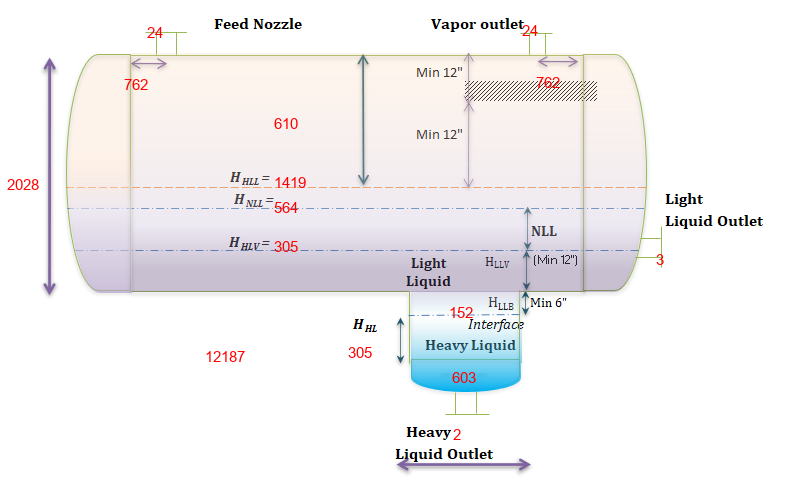

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,2028.41628
1,Vessel Tan-Tan Length,L,mm,12186.62949
2,L/D,-,-,6.00795
3,Shell Thickness,ts,mm,10.0025
4,Head Thickness,tH,mm,10.0025
5,Total Weight,W,kg,6688.51717
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,3.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [11]:

#  ---------H3P with boots---------------- # 

def find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= True):
	Lmin_Ltime , Lmin_V	= -10 , -2 
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated 
			H_v = max(0.2*D,2) 
		else: 
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1
		

		while not 1.2 > (Lmin_Ltime/ Lmin_V) > 0.8 and Lmin_Ltime < 0:
			At = np.pi*0.25*(D**2)
			Hv_D = H_v/(D) # feet / feet
			
			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At

			# step 7: set the heights of H_HL and H_LL
			

			A_LLV = height_area_conversion(H_LLV/D ,conversion_to_area = True)*At
			# 9 calculate minimum length
			Lmin_Ltime = (V_H+V_S)/(At-A_v-A_LLV)

			#calculate actual vapor velocity
			# Liquid dropout time 
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v
			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi
			if abs(Lmin_Ltime / Lmin_V) > 1.2 and H_v > min_Hv:
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(Lmin_Ltime / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.02
				Hv_D = H_v/(D)			
			if Lmin_Ltime <0 :
				D +=0.01
				Hv_D = H_v/(D)
	# print('Hv/D equals {} as D is {} feet and Hv is {} feet'.format(round(Hv_D,3),D,H_v))
	# print('Av is {}'.format(A_v))
	# print('Lmin1 is {} while Lmin2 is {}'.format(round(Lmin_Ltime,2),round(Lmin_V,2)))
	if Lmin_Ltime < Lmin_V:
		L = Lmin_V
	else:
		L = Lmin_Ltime
	#print(D,L)
	U_HL = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True) # velocity of the heavy liq out of the light liq in in/min.
	U_LH = terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False)

	t_HL = 12*(H_LLB+D-H_v)/U_HL
	#t_LH = 12*H_HL/U_LH
	phi_LL = (At-A_v)*L/Q_LL
	#print('t_HL is {} while phi_LL is {}'.format(t_HL,phi_LL))
	L_max2 = (t_HL*Q_LL)/(At-A_v)
	L = max(L,L_max2)
	#print('max length is {}, chosen L is {}'.format(round(L_max2,2),L))
	LD = L/D
	H_LL = D - H_v 
	A_NLL = (A_LLV) + V_H/L
	NLL = height_area_conversion(A_NLL/At,conversion_to_area = False)*D
	H_LLV_calculated  = H_LL-NLL
	#print('Assumed H_LLV is {} while calculated H_LLV is {}'.format(H_LLV,H_LLV_calculated))
	if return_output_LD == True:
		return [At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,H_v]
	else:
		return LD	

def optimize_vessel_design_withBoot(vars,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output = False):
	D,H_LLV,H_LLB = vars
	At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,H_v = find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= True)

	# step 24: Calculate Boot diameter 
	H_HL,t_LH , phi_HL = 1, 1,0
	while t_LH > phi_HL:
		H_HL = H_HL + 0.001
		U_p = 0.75 * U_LH
		D_boot = np.sqrt((4*12*Q_HL)/(np.pi*U_p))
		t_LH = 12*H_HL/U_LH 
		phi_HL = (np.pi*(D_boot**2)*H_HL)/(4*Q_HL)	
		
	# print('D is {}, Chosen L is {}, Hv is {}, HLL is {}, NLL is {}, HLLV is {},HLLB is {} and H_HL is {}'.format(D,L,H_v,H_LL, NLL, H_LLV,H_LLB,H_HL))
	# print('Boot Diameter is {} ft'.format(D_boot))
	W,t,As,AH,P,T,head_type = weight_calculations(P,T,D,L,17500,1/16,'Dished heads')
	W_boot,t_boot,As_boot,AH_boot,P_boot,T_boot,head_type_boot = weight_calculations(P,T,D_boot,(H_LLB+H_HL),17500,1/16,'Dished heads',boot=True)
	W = W + W_boot
	# print(W,L,D,LD)
	# print('---------------------')
	if return_output == False:
		return W 
	else:
		result_list = [D_boot,W,L,D,H_v,H_HL, H_LL ,t,As,AH,P,T,At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,head_type  ]
		return result_list

def LD_constraint_boot6(x,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	D,H_LLV,H_LLB = x[0],x[1],x[2]
	return 6 - find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= False)
def LD_constraint_boot1_5(x,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	D,H_LLV,H_LLB = x[0],x[1],x[2]
	return find_LD_HwithBoot(D,U_v,H_LLV,H_LLB,V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD= False) - 1.5

def detailed_V3H_with_boot(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
    Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T= operating_conditions
    hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
    Q_L_mix = Q_oil_lb+ Q_water_lb
    rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
    Ql_mix = Q_L_mix/(60*rho_L)
    sg_oil = rho_oil/62.4
    Qv = Qg_lb /(3600*rho_gas)
    Ql = Q_oil_lb/(60*rho_oil)
    V_H , V_S = hold_up_time*Ql ,surge_time*Ql # ft3
    Q_LL = Q_oil_lb/(60*rho_oil) # ft3/min
    Q_HL = Q_water_lb/(60*rho_water) # ft3/min
    # 1. Calculate Terminal Velocity   
    gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
    # 1. Calculate Terminal Velocity   

    K = k_GPSA_calculations(P,'Separator without mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
    U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
    # set U_v = 0.75 U_t
    U_v = 0.75* U_t

    # print('Qv is {} ft3/s,QLL is {} ft3/min and QHL is {} ft3/min'.format(round(Qv,2),round(Q_LL,2),round(Q_HL,2)))
    #step 5
    LD = LD_estimate(P) # LD initial estimate (assumption)
    Qhl = Q_water_lb/(60*rho_water)
    gas_vol_fraction = Qv*60/((Qv*60)+Q_LL+Q_HL)
    Q_L_mix = Q_oil_lb+ Q_water_lb
    rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
    Ql_mix = Q_L_mix/(60*rho_L)
    inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
    # print('Estimated LD is {}'.format(LD))
    # print('VHoldup and Vsurge equals {} and {} , total is {} ft3 '.format(round(V_H),round(V_S),(round(V_H)+round(V_S))))
    initial_D = ((4*(V_H + V_S))/(np.pi*0.6*LD))**(1/3) # D in feet
    D = initial_D

    if mist_eliminator: # step 6. used for initial guess and to be minpulated 
        H_v = max(0.2*initial_D,2) 
    elif gas_mass_fraction*100 > 70:
        H_v = 0.7* initial_D
    else: 
        H_v = max(0.2*initial_D,1) # Hv in feet
	#con1,con2,con3,con4 = {'type':'ineq', 'fun': constraint_HP3_Hv_boot, 'args':(V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water)},{'type':'eq', 'fun':constraint_HP3_boot_LD_init, 'args':(V_S,V_H)},	{'type':'ineq', 'fun': LD_constraint_boot1_5, 'args':(V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water)},{'type':'ineq', 'fun': LD_constraint_boot6, 'args':(V_S,V_H,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water)} #,{'type':'ineq', 'fun': HLLV_constraint, 'args':(V_S,V_H)}
	#cons=[con1,con2,con3,con4]
    con1,con2 = {'type':'ineq', 'fun':LD_constraint_boot6,'args':(V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)},{'type':'ineq', 'fun':LD_constraint_boot1_5,'args':(V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)}
    cons = [con1,con2]
    initial_guess = [initial_D,1,0.5]
    if mist_eliminator:
        min_Hv = 2
    else: min_Hv = 1
    bounds = [(1,20),(1,20),(0.5,20)]
    result =minimize(optimize_vessel_design_withBoot,args=(P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001,constraints=cons) 
    result_list = optimize_vessel_design_withBoot(result.x,P,T,V_S,V_H,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output=True)
    D_boot,W,L,D,H_v,H_HL, H_LL ,t,As,AH,P_d,T_d,At,Hv_D,A_v,H_LLV,H_LLB,A_LLV,Lmin_Ltime,phi,U_VA,Lmin_V,L,U_HL,U_LH,t_HL,phi_LL,L_max2,L,LD,H_LL,A_NLL,NLL,H_LLV_calculated,head_type  = result_list
    #print('W {},D {},L {}, L/D {},t {},D_boot {},H_v {},H_LL {},NLL {},H_LLV {},H_LLB {},H_HL {}'.format(W*0.45,D*304.8,L*304.8,LD,t*25.4,D_boot*304.8,H_v*304.8,H_LL*304.8,NLL*304.8,H_LLV*304.8,H_LLB*304.8,H_HL*304.8))

    d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
    gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
    liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
    liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)
    gas_N = Calculate_N(gas_outlet_D)
    liquid_H_N = Calculate_N(liquid_H_outlet_D)
    Feed_N = Calculate_N(d_n)


    Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_L_outlet_D,liquid_H_outlet_D  ,D*304.8,L*304.8,D_boot*304.8,H_v*304.8,H_LL*304.8,NLL*304.8,H_LLV*304.8,H_LLB*304.8,H_HL*304.8]
    for i,j in enumerate(Dims_results):
        Dims_results[i] = round(float(j))
    coord = [(147,24),(124,76),(522,22),(536,74),(656,251),(453,426),(7,176),(205,348),(452,369),(274,115),(274,174),(274,199),(274,238),(449,304),(348,344)
    ] # vap outlet, diameter, total_H,HLIN,HS,HH,HLLL,HD,liquid_outlet_D
    list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
	['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
	['Low Light Liquid Level', 'HLLV', 'mm', H_LLV*304.8],
	['Normal Light Liquid Level', 'HNLL', 'mm', NLL*304.8],
	['High Light Liquid Level', 'HHLL', 'mm', H_LL*304.8],
	['Boot Light Liquid Level', 'HLLB', 'mm', H_LLB*304.8],
	['High Heavy Liquid Level', 'HHL', 'mm', (H_HL)*304.8],
	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]
    if not mist_eliminator:
        write_results_on_imgs('detailed_method_V3H_boot',Dims_results,coord)
    else:
        write_results_on_imgs('detailed_method_V3H_boot_with_mesh',Dims_results,coord)
    summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=True)
    return summary_table

# Calculations inputs 
Qg_lb, rho_gas = 235000,0.19 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 45000,7500,40.5,62.00
mu_oil,mu_water = 0.24, 0.682
sg_oil = rho_oil/rho_water
P = 25 + 14.6959 # psia
T = 100 # F
inlet_divertor, mist_eliminator = False,True
sep_case = 'Unit Feed Drum'
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
summary_table  = detailed_V3H_with_boot(operating_conditions,sep_case,inlet_divertor,mist_eliminator)
summary_table

# 6. Horizontal Three-Phase Separator Sizing (With weir)
![Example Image](vessel_imgs/detailed_method_V3H_weir_with_mesh.png)

1.  Calculate the vapor volumetric flow rate

> Q<sub>v</sub>= W<sub>v</sub> / (3600\* ρ<sub>v</sub>) ,ft<sup>3</sup>/s

2.  Calculate the light and the heavy liquid volumetric flow rates,
    Q<sub>LL­</sub> and Q<sub>HL</sub>

3.  Calculate vertical terminal vapor velocity:

> U<sub>T</sub> = K\* ((ρ<sub>L</sub>- ρ<sub>v</sub>)/
(ρ<sub>v</sub>))<sup>1/2</sup>

> U<sub>v</sub> =0.75\* U<sub>T</sub>

4.  Select holdup time from table 2 and calculate the holdup volume

> V<sub>H</sub> = T<sub>H</sub> \* Q<sub>L</sub> ,ft<sup>3</sup> , If
surge volume isn’t specified. Select a surge time from table 2 and
calculate surge volume

> V<sub>S</sub> = T<sub>S</sub> \* Q<sub>L</sub> ,ft<sup>3</sup>

5.  Obtain L/D from table 7 and initially calculate the diameter
    according to:

> D = (16(V<sub>H</sub> + V<sub>S</sub>)/(0.6π(L/D)))<sup>1/3</sup>

6.  Set the vapor space height, H<sub>v</sub>, the larger of 0.2D or 2
    ft; 1ft if there is no mist eliminator. Using H<sub>v</sub>/D in
    table 3, obtain A<sub>v</sub>/A<sub>T</sub> and calculate
    A<sub>v</sub>.

7.  Calculate the low liquid level in the light liquid compartment
    using:

> H<sub>LLL</sub> = 0.5D + 7 (D in feet, H<sub>LLL</sub> is inches), If D
\< 4.0, H<sub>LLL</sub> = 9 inches

Calculate A<sub>LLL</sub> form H<sub>LLL</sub>/D (both in feet or
inches)

8.  Calculate the weir height:

> H<sub>w</sub> = D - H<sub>v</sub>

If H<sub>w</sub> \< 2 ft increase D and repeat calculations from Step 6.

9.  Calculate the minimum length of the light liquid compartment to
    accommodate the liquid holdup/surge:

> L<sub>2</sub> = (V<sub>H</sub> + V<sub>S</sub>) / (A<sub>T</sub> –
A<sub>v</sub> –A<sub>LLL</sub>) , ft

Round to the nearest 0.5 ft. With L<sub>2</sub> minimum as
d<sub>N</sub> + 12

10.  Set the interface height as H<sub>w</sub>/2, obtaining the heights
    of heavy and light liquids H<sub>HL</sub>, H<sub>LL</sub>.

11.  For the liquid settling compartment, calculate the cross sectional
    area if the heavy liquid by H<sub>HL</sub>/D and calculate the cross
    sectional area of the liquid liquid from:

> A<sub>LL</sub> = A<sub>T</sub> – A<sub>v</sub> – A<sub>HL</sub>

12.  Calculate the setting velocities of the heavy liquid out of the
    light liquid phase and the light liquid out of the heavy phase:

> U<sub>HL</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
ρ<sub>L</sub>)/μ<sub>L</sub>

> U<sub>LH</sub> = K<sub>s</sub> (ρ<sub>H</sub>-
ρ<sub>L</sub>)/μ<sub>H</sub>

13.  Calculate the settling times of the heavy liquid out of the light
    phase and the light liquid out of the heavy phase:

> t<sub>HL</sub> = 12 (D-H<sub>v</sub> – H<sub>HL</sub>)/U<sub>HL</sub>

> t<sub>LH</sub> = 12 H<sub>HL</sub> / U<sub>LH</sub>

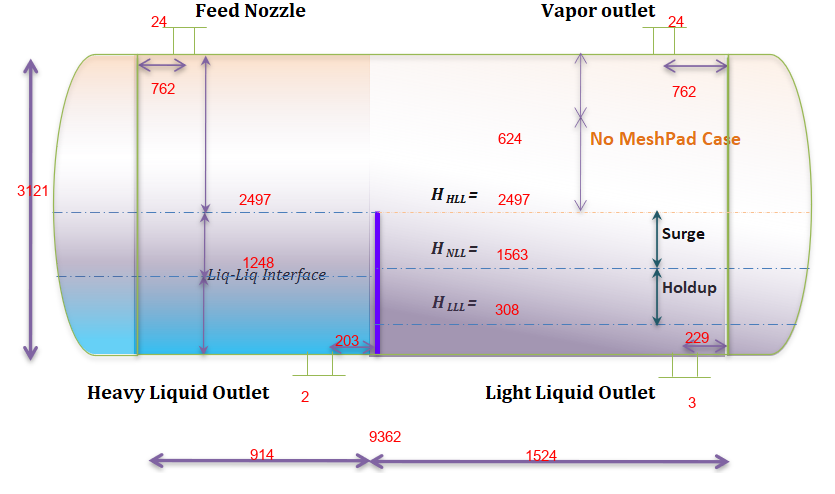

,parameter,Symbols,Units,Value
0,Diameter of Drum,D,mm,3120.66666
1,Vessel Tan-Tan Length,L,mm,9362.0003
2,L/D,-,-,3.0
3,Shell Thickness,ts,mm,11.80294
4,Head Thickness,tH,mm,11.80294
5,Total Weight,W,kg,10022.30812
6,Inlet Nozzle size,dF,inch,24.0
7,Light Liquid Outlet Nozzle size,dL,inch,3.0
8,Heavy Liquid Outlet Nozzle size,dL,inch,2.0
9,Vapor Outlet Nozzle size,dv,inch,24.0


In [10]:
#  ---------H3P with Weir---------------- # 
def find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = True):


	L_total , Lmin_V,L2	= -10 , -2 ,-10
	H_v , min_Hv = 0.5,1
	while (H_v < min_Hv) :
		if mist_eliminator: # used for initial guess and to be minpulated 
			H_v = max(0.2*D,2) 
		else: 
			H_v = max(0.2*D,1) # Hv in feet
		if mist_eliminator:
			min_Hv = 2
		else: min_Hv = 1
		while not 1.2 > abs(L_total/ Lmin_V) > 0.8 and L2 < 0 :
			D = float(D)
			At = np.pi*0.25*(D**2) # ft2
			Hv_D = H_v/(D) # feet / feet
			
			A_v  = height_area_conversion(Hv_D ,conversion_to_area = True)*At

			# step 7: set the heights of H_HL and H_LL
			H_LLL = (0.5*D+7)/12 # feet
			H_w = D-H_v

			#if H_w <2:
			#D+=0.01

			A_LLL = height_area_conversion(H_LLL/D ,conversion_to_area = True)*At
			
			# 9 calculate minimum length
			L2 = np.ceil((V_H+V_S)/(At-A_v-A_LLL)) #max(,dn+1) # L2
			if return_output_LD == 'L2':
				return L2
			
			
			#calculate actual vapor velocity
			# Liquid dropout time 
			phi = H_v/U_v

			# Actual vapor velocity
			U_VA = Qv/A_v
			# minimum velocity for vapor-liquid disengagement
			Lmin_V = U_VA*phi


			#set interface at hw/2
			H_LL,H_HL = H_w/2,H_w/2


			A_HL = height_area_conversion(H_HL/D ,conversion_to_area = True)*At
			A_LL = At - A_v- A_HL

			U_HL = min(terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=True),10) # max. velocity is 10 in/min
			U_LH = min(terminal_2phase_svrcek(sg_oil,rho_oil,rho_water,mu_oil,mu_water,High=False),10) # max. velocity is 10 in/min

			t_HL = 12*(H_LL)/U_HL
			t_LH = 12*H_HL/U_LH

			L1 = np.ceil(max(t_LH*Q_HL/A_HL,t_HL*Q_LL/A_LL))
			
			
			
			L_total = L1 + L2
			if abs(L_total / Lmin_V) > 1.2 and H_v > min_Hv:
				H_v -=0.01
				Hv_D = H_v/(D)
			elif not abs(L_total / Lmin_V) < 0.8:
				H_v +=0.01
				Hv_D = H_v/(D)
			if H_v < min_Hv:
				D +=0.01
				H_v +=0.02
				Hv_D = H_v/(D)			
			if L2 <0 :
				D +=0.01
				Hv_D = H_v/(D)
	if L_total < Lmin_V:
		L = Lmin_V
		# set new L1 and L2
	else:
		L = L_total
	# print('Uav is {} while  phi is {}'.format(round(U_VA,2),round(phi,2)))
	# print('Lmin1 is {} while Lmin2 is {}'.format(round(L2,2),round(Lmin_V,2)))
	# print('Hv/D equals {} as D is {} feet and Hv is {} feet'.format(round(Hv_D,3),D,H_v))
	# print('Hw is {}'.format(H_w))
	# print('At {},Av equals {}, A_LLL equals {}, L2 {}'.format(At,A_v,A_LLL,L2))	
	# print('U_HL is {} in/min. U_LH is {} in/min. t_HL = {} mins and t_LH is {} mins'.format(round(U_HL,2),round(U_LH,2),round(t_HL,2),round(t_LH,2)))
	# print('first option for L1 is {}, second is {}, {} was selected'.format(t_LH*Q_HL/A_HL,t_HL*Q_LL/A_LL,L1))		
	# print('L1 = {}, L2 = {}. Consequently L total is {} while Lmin is {}. Selected L is {} '.format(round(L1,2),round(L2,2),round(L_total,2),round(Lmin_V,2),round(L,2)))
	phi_LL = (At-A_v)*L/Q_LL
	L_max2 = (t_HL*Q_LL)/(At-A_v)
	L = max(L,L_max2)
	
	if return_output_LD == True:
		return [At,Hv_D,A_v,H_LLL,H_w,A_LLL,L2,phi,U_VA,Lmin_V,H_LL,H_HL,A_HL,A_LL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,L_max2,L,H_v]
	else:
		return L/D
def optimize_vessel_design_HwithW(vars,P,T,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output = False):
	D = float(vars)

	
	At,Hv_D,A_v,H_LLL,H_w,A_LLL,L2,phi,U_VA,Lmin_V,H_LL,H_HL,A_HL,A_LL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,L_max2,L,H_v = find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = True)
	# print('max length is {}'.format(round(L_max2,2)))
	LD = L/D
	# print('Calculated L/D is {}'.format(LD))
	W,t,As,AH,P,T,head_type = weight_calculations(P-14.6959,T,D,L,17500,1/16,'Dished heads',E=0.85)

	H_HLL = D - H_v 
	A_NLL = A_LLL + V_H/L2 
	H_NLL = height_area_conversion(A_NLL/At,conversion_to_area = False)*D
	# print('Diameter is {} ft, Hv is {} ft,H_LL & H_HL are {} and {} ft'.format(round(float(D),2),round(float(H_v),2),round(H_LL,2),round(H_HL,2)))
	# print(W,L,D,LD)
	# print('---------------------')
	if return_output == False:
		return W 
	else:
		result_list = [W,L,D,H_v,t,As,AH,P,T,At,A_v,H_LLL,H_w,L2,phi,U_VA,Lmin_V,H_LL,H_HL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,H_HLL,H_NLL,LD,head_type]
		return result_list

def constraint_H3P_weir_1_5(x,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	# assumed LD equals calculated LD
	D = x[0]
	return find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = False) - 1.5
def constraint_H3P_weir_6(x,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator):
	# assumed LD equals calculated LD
	D= x[0]
	return 3 - find_LD_weir(D,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output_LD = False)
def detailed_V3H_with_weir(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False):
	Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T= operating_conditions
	hold_up_time,surge_time=hold_surge_table_index[sep_case][0],hold_surge_table_index[sep_case][1]
	Q_L_mix = Q_oil_lb+ Q_water_lb
	rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
	Ql_mix = Q_L_mix/(60*rho_L)
	sg_oil = rho_oil/62
	# 1. Calculate Terminal Velocity   
	Qv = Qg_lb /(3600*rho_gas)
	Ql = Q_oil_lb/(60*rho_oil)
	V_H , V_S = hold_up_time*Ql ,surge_time*Ql # ft3
	Q_LL = Q_oil_lb/(60*rho_oil) # ft3/min
	Q_HL = Q_water_lb/(60*rho_water) # ft3/min
	# print('Qv is {} ft3/s,QLL is {} ft3/min and QHL is {} ft3/min'.format(round(Qv,2),round(Q_LL,2),round(Q_HL,2)))
	gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
	d_n = inlet_nozzzle_sizing(Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)
	gas_mass_fraction = Qg_lb/(Q_oil_lb+Q_water_lb+Qg_lb)
	Qhl = Q_water_lb/(60*rho_water)
	gas_vol_fraction = Qv*60/((Qv*60)+Q_LL+Q_HL)
	# print('gas_vol_fraction is {}'.format(gas_vol_fraction))
	# print('gas_mass_fraction is {}'.format(gas_mass_fraction))
	Q_L_mix = Q_oil_lb+ Q_water_lb
	rho_L =(Q_oil_lb/(Q_L_mix))*rho_oil+(Q_water_lb/(Q_L_mix))*rho_water
	Ql_mix = Q_L_mix/(60*rho_L)
	# 1. Calculate Terminal Velocity   

	K = k_GPSA_calculations(P,'Separator without mist eliminator',rho_gas,rho_oil,0.013,dropletsize=100)
	U_t = K *np.sqrt((rho_oil-rho_gas)/rho_gas)
	# set U_v = 0.75 U_t
	U_v = 0.75* U_t

	#step 5
	LD = LD_estimate(P) # LD initial estimate (assumption)

	# print('Estimated LD is {}'.format(LD))
	# print('VHoldup and Vsurge equals {} and {} , total is {} ft3 '.format(round(V_H),round(V_S),(round(V_H)+round(V_S))))
	initial_D = round(((16*(V_H + V_S))/(np.pi*0.6*LD))**(1/3)) # D in feet

	# print('inital Diameter is {}'.format(initial_D))

	#print('--------------------------')
	con1,con2 = {'type':'ineq', 'fun': constraint_H3P_weir_1_5, 'args':(V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)},{'type':'ineq', 'fun': constraint_H3P_weir_6, 'args':(V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator)} # {'type':'ineq', 'fun': constraint_HP2_2},
	cons = [con1,con2]

	initial_guess = [initial_D]

	bounds = [(1,20)]
	result =minimize(optimize_vessel_design_HwithW,args=(P,T,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.001,constraints=cons) #, constraints= cons)
	result_list = optimize_vessel_design_HwithW(result.x,P,T,V_H,V_S,U_v,Qv,Q_HL,Q_LL,sg_oil,rho_oil,rho_water,mu_oil,mu_water,mist_eliminator,return_output=True)
	W,L,D,H_v,t,As,AH,P_d,T_d,At,A_v,H_LLL,H_w,L2,phi,U_VA,Lmin_V,H_LL,H_HL,U_HL,U_LH,t_HL,t_LH,L1,phi_LL,H_HLL,H_NLL,LD,head_type = result_list



	d_n = inlet_nozzzle_sizing(Qv,Ql_mix,rho_gas,rho_L,gas_vol_fraction)
	gas_outlet_D = inlet_nozzzle_sizing(Qv,0,rho_gas,0,1,True)
	liquid_L_outlet_D = inlet_nozzzle_sizing(Q_LL/60,0,rho_oil,0,1,True)
	liquid_H_outlet_D = inlet_nozzzle_sizing(Q_HL/60,0,rho_water,0,1,True)
	gas_N = Calculate_N(gas_outlet_D)
	liquid_L_N = Calculate_N(liquid_L_outlet_D)
	liquid_H_N = Calculate_N(liquid_H_outlet_D)
	Feed_N = Calculate_N(d_n)
	Dims_results = [d_n,Feed_N, gas_outlet_D, gas_N,liquid_L_outlet_D,liquid_L_N,liquid_H_outlet_D,liquid_H_N,L*304.8 ,D*304.8,L1*304.8,L2*304.8,H_HLL*304.8,H_NLL*304.8,H_LLL*304.8,(H_HL+H_LL)*304.8,H_LL*304.8,H_v*304.8]
	for i,j in enumerate(Dims_results):
		Dims_results[i] = round(float(j))
	coord = [(151,13),(151,80),(668,13),(672,83),(688,394),(685,329),(301,388),(335,332),(369,428),(17,182),(250,446),
	(525,447),(498,191),(496,246),(495,301),(239,191),(242,254),(498,130)]
	list_of_table = [['Diameter of Drum', 'D', 'mm', D*304.8],
	['Vessel Tan-Tan Length', 'L', 'mm',L*304.8],
	['L/D','-', '-', LD],
	['Shell Thickness', 'ts', 'mm', t*25.4],
	['Head Thickness', 'tH', 'mm', t*25.4],
	['Total Weight', 'W', 'kg', W*0.453592],
	['Inlet Nozzle size', 'dF', 'inch', d_n],
	['Light Liquid Outlet Nozzle size', 'dL', 'inch', liquid_L_outlet_D],
	['Heavy Liquid Outlet Nozzle size', 'dL', 'inch', liquid_H_outlet_D],
	['Vapor Outlet Nozzle size', 'dv', 'inch', gas_outlet_D],
	['Low Light Liquid Level', 'HLLL', 'mm', H_LLL*304.8],
	['Normal Light Liquid Level', 'HNLL', 'mm', H_NLL*304.8],
	['High Light Liquid Level', 'HHLL', 'mm', H_HLL*304.8],
	['Low Heavy Liquid Level', 'HLLL', 'mm', H_LL*304.8],
	['High Heavy Liquid Level', 'HHLL', 'mm', (H_HL+H_LL)*304.8],
	['Holdup Time', 'TH', 'min', hold_up_time],
	['Surge Time', 'TS', 'min',surge_time],
	['MeshPad', '-', '-', mist_eliminator],
	['Head Type', '-', '-', head_type],
	['Material/Alloy grade and type:', np.nan, np.nan, 'CS'],
	['Max. Operating Pressure', 'MOP', 'Barg', P],
	['Design Pressure', 'DP', 'Barg', P_d],
	['Design Temperature', 'DT', 'oC', T_d],
	['Corrosion Allowance', 'C', 'mm', 1.5],
	['Joint Efficiency', 'E', '-',  0.85]]

	if not mist_eliminator:
		write_results_on_imgs('detailed_method_V3H_weir',Dims_results,coord)
	else:
		write_results_on_imgs('detailed_method_V3H_weir_with_mesh',Dims_results,coord)
	summary_table = create_and_view_summary_table(list_of_table,list_of_columns=['parameter','Symbols','Units','Value'],show_table=False)
	return summary_table

# Calculations inputs 
Qg_lb, rho_gas = 235000,0.19 # lb/hr and lb/ft3
Q_oil_lb, Q_water_lb, rho_oil, rho_water = 45000,7500,40.5,62.00
mu_oil,mu_water = 0.24, 0.682
sg_oil = rho_oil/rho_water
P = 25 + 14.6959 # psia
T = 100 # F
inlet_divertor, mist_eliminator = False,True
sep_case = 'Unit Feed Drum'
operating_conditions = Qg_lb, rho_gas,Q_oil_lb, Q_water_lb, rho_oil, rho_water,mu_oil,mu_water,P,T
summary_table =detailed_V3H_with_weir(operating_conditions,sep_case,inlet_divertor=False,mist_eliminator=False)

summary_table


# Final Thoughts 
I have used the recommended L/D ratios mentioned in the article. <br> 
Some resources would recommend L/D betwwen 3-4 or 3-5 based on the vessel type. <br>
you can always change the L/D constraint for each separator and adjust it to whatever you want!


In [1]:
# you can ignore This section!

from pyXSteam.XSteam import XSteam
import pyXSteam
steam_table = XSteam(XSteam.UNIT_SYSTEM_MKS)
steam_table.rho_pt(1.2,1)
steam_table = XSteam(XSteam.UNIT_SYSTEM_FLS)
steam_table.rho_pt(25 + 14.6959,100),steam_table.my_pt(25 + 14.6959,100)*0.41337887 #Convert lbm/ft/hr to cP

def water_props(P,T):
    steam_table = XSteam(XSteam.UNIT_SYSTEM_FLS)
    rho_water,mu_water = steam_table.rho_pt(P,T),steam_table.my_pt(P,T)*0.41337887 #Convert lbm/ft/hr to cP
    return rho_water,mu_water
water_props(1,1.8*45+32)


(0.0029382906943560393, 0.010464708305126646)